In [237]:
import os
import sys
from os.path import join
import json
import multiprocessing


# Supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tqdm import tqdm
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import nfl_data_py as nfl
import statsmodels.api as sm

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(ROOT_DIR,'py'))

import util
from plot.plot_simple import plot_play_with_speed

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

with open("paths.json", 'r') as f:
    paths = json.load(f)

RAW_DATA_PATH = paths['raw_data']
PROCESSED_DATA_PATH = paths['processed_data']

# Load and Filter the Data

In [2]:
run_concepts = pd.read_pickle(join(PROCESSED_DATA_PATH, 'run_concepts.pkl'))

motion = pd.DataFrame()
for wk in range(1,10):
    motion_tmp = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'motion_plays.pkl'))
    motion = pd.concat([motion, motion_tmp])
motion = motion.reset_index(drop=True)
motion['motion_group'] = motion.motion_group.fillna('DROP')

df = run_concepts.merge(motion, on='game_play_id', how='left')
df['game_id'] = df.game_play_id.apply(lambda x: x.split('_')[0]).astype(int)

games = pd.DataFrame()
for wk in range(1,10):
    game_tmp = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'games.pkl'))
    games = pd.concat([games, game_tmp[['game_id','home_team_abbr']]])
df = df.merge(games, on='game_id', how='left')

df = df[df.motion_group != 'DROP']

df.drop(columns=['game_id'], inplace=True)

df['motion_present'] = ~df.motion_nfl_id.isnull()

del motion_tmp, game_tmp, motion, run_concepts, games

In [3]:
df['motion_towards_playside'] = np.where(
    df.motion_present,
    np.where(
        (df.play_dir_location.isin(['inside-left', 'outside-left']) & (df.motion_dir_last == 'left')) |
        (df.play_dir_location.isin(['inside-right', 'outside-right']) & (df.motion_dir_last == 'right')),
        1,
        np.where(
            df.play_dir_location == 'middle',
            0,
            -1
        ),
    ),
    np.nan
)

drop_cols = ['play_dir', 'motion_nfl_id', 'motion_position',
             'initial_alignment', 'n_direction_changes', 'same_motion_dir',
             'motion_dir_first', 'motion_dir_last', 'motion_sub_group']
for c in drop_cols:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

In [4]:
cols = ['game_play_id', 'game_id',
       'down', 'yards_to_go', 
       'possession_team', 'defensive_team', 
       'pre_snap_home_score','pre_snap_visitor_score',
       'absolute_yardline_number', 
       'pre_snap_home_team_win_probability',
       'offense_formation', 'defenders_in_box', 
       'expected_points_added',
       'yards_gained']

df_play = pd.DataFrame()
for wk in range(1, 10):
    tmp = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'play_final.pkl'))
    df_play = pd.concat([df_play, tmp[cols]])

df_play = df_play.reset_index(drop=True)

del tmp

In [5]:
# add week to df_play
df_game = pd.DataFrame()
for wk in range(1, 10):
    tmp = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'games.pkl'))
    df_game = pd.concat([df_game, tmp[['game_id','week']]])

if 'week' in df_play.columns:
    df_play.drop(columns='week', inplace=True)
df_play = df_play.merge(df_game, on='game_id', how='left')

In [6]:
df = df.merge(df_play, on='game_play_id', how='left')

In [7]:
# Drop "DRAW" plays as they dont fall into Zone, Gap, or Man concepts
df = df.query('run_concept != "DRAW"').reset_index(drop=True)

df.query('motion_present == 1').value_counts('run_concept')

run_concept
OUTSIDE ZONE    624
INSIDE ZONE     380
MAN             310
POWER           202
PULL LEAD       187
COUNTER         119
TRAP             22
dtype: int64

In [8]:
(
    df
    .query('~motion_group.isin(["In","Shuffle"])')
    .value_counts(['run_concept', 'motion_group'])
    .reset_index().rename(columns={0:'count'})
    .sort_values(['run_concept', 'count'], ascending=[True, False])
)

run_concept motion_group  count
16       COUNTER          Jet     37
23       COUNTER        Orbit     26
25       COUNTER          Fly     22
32       COUNTER         Over     13
34       COUNTER        Yo-Yo     11
35       COUNTER        Glide      8
1    INSIDE ZONE          Jet    155
5    INSIDE ZONE        Orbit     77
11   INSIDE ZONE          Fly     50
17   INSIDE ZONE        Yo-Yo     36
21   INSIDE ZONE         Over     31
22   INSIDE ZONE        Glide     29
4            MAN          Jet     95
9            MAN        Glide     56
12           MAN        Orbit     48
13           MAN          Fly     45
14           MAN         Over     42
30           MAN        Yo-Yo     18
0   OUTSIDE ZONE          Jet    256
2   OUTSIDE ZONE        Orbit    121
3   OUTSIDE ZONE         Over    112
7   OUTSIDE ZONE          Fly     59
15  OUTSIDE ZONE        Yo-Yo     39
28  OUTSIDE ZONE        Glide     19
6          POWER          Jet     66
10         POWER         Over     56
24         POWER        Orbit     23
26         POWER        Glide     21
27         POWER          Fly     21
31         POWER        Yo-Yo     13
8      PULL LEAD          Jet     57
18     PULL LEAD        Orbit     36
19     PULL LEAD        Glide     32
20     PULL LEAD         Over     32
29     PULL LEAD          Fly     18
33     PULL LEAD        Yo-Yo     12
36          TRAP          Jet      5
37          TRAP        Yo-Yo      5
38          TRAP          Fly      4
39          TRAP        Orbit      3
40          TRAP         Over      3
41          TRAP        Glide      2

In [12]:
# Drop "Trap" plays due to small sample size and "In" and "Shuffle" motion groups for same reason
df = df.query('~((run_concept == "TRAP") or motion_group.isin(["In","Shuffle"]))').reset_index(drop=True)
df.query('motion_present == 1').value_counts('run_concept')

run_concept
OUTSIDE ZONE    606
INSIDE ZONE     378
MAN             304
POWER           200
PULL LEAD       187
COUNTER         117
dtype: int64

In [13]:
df.query('motion_present == 1').value_counts('motion_group')

motion_group
Jet      666
Orbit    331
Over     286
Fly      215
Glide    165
Yo-Yo    129
dtype: int64

In [14]:
(
    df
    .query('~motion_group.isin(["In","Shuffle"])')
    .value_counts(['run_concept', 'motion_group'])
    .reset_index().rename(columns={0:'count'})
    .sort_values(['run_concept', 'count'], ascending=[True, False])
)

run_concept motion_group  count
16       COUNTER          Jet     37
23       COUNTER        Orbit     26
25       COUNTER          Fly     22
32       COUNTER         Over     13
34       COUNTER        Yo-Yo     11
35       COUNTER        Glide      8
1    INSIDE ZONE          Jet    155
5    INSIDE ZONE        Orbit     77
11   INSIDE ZONE          Fly     50
17   INSIDE ZONE        Yo-Yo     36
21   INSIDE ZONE         Over     31
22   INSIDE ZONE        Glide     29
4            MAN          Jet     95
9            MAN        Glide     56
12           MAN        Orbit     48
13           MAN          Fly     45
14           MAN         Over     42
30           MAN        Yo-Yo     18
0   OUTSIDE ZONE          Jet    256
2   OUTSIDE ZONE        Orbit    121
3   OUTSIDE ZONE         Over    112
7   OUTSIDE ZONE          Fly     59
15  OUTSIDE ZONE        Yo-Yo     39
28  OUTSIDE ZONE        Glide     19
6          POWER          Jet     66
10         POWER         Over     56
24         POWER        Orbit     23
26         POWER        Glide     21
27         POWER          Fly     21
31         POWER        Yo-Yo     13
8      PULL LEAD          Jet     57
18     PULL LEAD        Orbit     36
19     PULL LEAD        Glide     32
20     PULL LEAD         Over     32
29     PULL LEAD          Fly     18
33     PULL LEAD        Yo-Yo     12

In [17]:
df['pos_team_is_home'] = df.possession_team == df.home_team_abbr
df['pre_snap_score_diff'] = np.where(
    df.pos_team_is_home,
    df.pre_snap_home_score - df.pre_snap_visitor_score,
    df.pre_snap_visitor_score - df.pre_snap_home_score
)
df['pre_snap_wp'] = np.where(
    df.pos_team_is_home,
    df.pre_snap_home_team_win_probability,
    1 - df.pre_snap_home_team_win_probability
)

In [18]:
cols = ['game_play_id', 'week', 'run_concept', 'play_dir_location',
       'possession_team', 'defensive_team',
       'motion_had_rush_attempt', 'pre_snap_motion_dist_traveled',
       'motion_group', 'motion_present',
       'motion_towards_playside', 'down', 'yards_to_go',
       'absolute_yardline_number',
       'offense_formation', 'defenders_in_box',
       'pre_snap_score_diff','pre_snap_wp',
       'yards_gained'] #'expected_points_added']

df = df[cols]

In [19]:
df.head()

game_play_id  week   run_concept play_dir_location possession_team  \
0  2022091105_3712     1  OUTSIDE ZONE      inside-right             IND   
1  2022091104_1094     1  OUTSIDE ZONE     outside-right             DET   
2  2022091101_3923     1   INSIDE ZONE            middle             CAR   
3  2022091106_1380     1   INSIDE ZONE      inside-right             MIA   
4   2022091100_501     1  OUTSIDE ZONE      outside-left              NO   

  defensive_team  motion_had_rush_attempt  pre_snap_motion_dist_traveled  \
0            HOU                      NaN                            NaN   
1            PHI                      0.0                       0.697350   
2            CLE                      NaN                            NaN   
3             NE                      0.0                       8.234742   
4            ATL                      0.0                       9.052830   

  motion_group  motion_present  motion_towards_playside  down  yards_to_go  \
0          NaN           False                      NaN     1           10   
1          Jet            True                      1.0     1           10   
2          NaN           False                      NaN     2           11   
3        Orbit            True                      1.0     1           10   
4        Orbit            True                      1.0     1           10   

   absolute_yardline_number offense_formation  defenders_in_box  \
0                        81        SINGLEBACK               6.0   
1                        35        SINGLEBACK               7.0   
2                        95        SINGLEBACK               8.0   
3                        18            I_FORM               7.0   
4                        33        SINGLEBACK               6.0   

   pre_snap_score_diff  pre_snap_wp  yards_gained  
0                   -7     0.221582            14  
1                    0     0.395236             1  
2                   -2     0.741719             0  
3                   10     0.847051             1  
4                   -3     0.618278             5

# Add Feature for Rush YPC by Offenses and Defenses over last X games
These features are confounding variables to the relationship between pre-snap motion and run yards.
- not including QB runs
- regular season games only

In [20]:
cols = ['old_game_id_x','posteam','defteam','season_type','rush','yards_gained',
        'rusher_id','penalty','season','week']
rename_dict = {
    'old_game_id_x':'game_id',
}
df_ypc = nfl.import_pbp_data(years=[2021,2022])[cols].rename(columns=rename_dict)

2021 done.
2022 done.
Downcasting floats.


In [21]:
df_ypc = (
    df_ypc
    .query('rush == 1 and penalty == 0 and season_type == "REG"')
    .reset_index(drop=True)
    .drop(columns=['rush','penalty','season_type'])
)

df_ypc.head()

game_id posteam defteam  yards_gained   rusher_id  season  week
0  2021091207     TEN     ARI          -3.0  00-0032764    2021     1
1  2021091207     ARI     TEN           0.0  00-0034681    2021     1
2  2021091207     TEN     ARI          -1.0  00-0032764    2021     1
3  2021091207     TEN     ARI           2.0  00-0032764    2021     1
4  2021091207     ARI     TEN           4.0  00-0034681    2021     1

In [22]:
cols = ['season','player_id','position']

df_ypc = (
    df_ypc.merge(
        nfl.import_seasonal_rosters(years=[2021,2022])[cols],
        left_on=['season','rusher_id'],
        right_on=['season','player_id'],
        how='left'
    )
    .drop(columns=['player_id','rusher_id'])
)

df_ypc.isna().sum()

game_id         0
posteam         0
defteam         0
yards_gained    0
season          0
week            0
position        0
dtype: int64

In [23]:
df_ypc['wk_idx'] = np.where(
    df_ypc.season == 2021,
    df_ypc.week,
    df_ypc.week + 17
)

In [24]:
df_ypc = df_ypc.query('position.isin(["RB","WR","TE"])').reset_index(drop=True)

In [25]:
ypcs = (
    df_ypc
    .groupby(['game_id','wk_idx','posteam','defteam'])
    .agg(
        ypc=('yards_gained','mean'),
    )
    .reset_index()
)

ypcs.head()

game_id  wk_idx posteam defteam       ypc
0  2021090900       1     DAL      TB  3.357143
1  2021090900       1      TB     DAL  3.714286
2  2021091200       1     ATL     PHI  4.608696
3  2021091200       1     PHI     ATL  4.520000
4  2021091201       1     BUF     PIT  4.562500

In [26]:
import pandas as pd
from scipy.optimize import minimize

def optimize_week(data, week, prev_weeks=10):
    # Filter data for the previous 10 weeks
    start_week = week - prev_weeks
    filtered_data = data[(data["wk_idx"] >= start_week) & (data["wk_idx"] < week)]
    
    teams = list(set(filtered_data["posteam"]).union(set(filtered_data["defteam"])))
    team_idx = {team: i for i, team in enumerate(teams)}
    
    n_teams = len(teams)
    
    # Initial guesses for offensive and defensive strengths
    x0 = [0] * (2 * n_teams)
    
    def objective(x):
        off_str = x[:n_teams]
        def_str = x[n_teams:]
        error = 0
        for _, row in filtered_data.iterrows():
            i = team_idx[row["posteam"]]
            j = team_idx[row["defteam"]]
            predicted_ypc = off_str[i] - def_str[j]
            error += (row["ypc"] - predicted_ypc) ** 2
        return error
    
    # Constraints: mean of offensive and defensive strengths should be 0
    constraints = [
        {"type": "eq", "fun": lambda x: sum(x[:n_teams])},
        {"type": "eq", "fun": lambda x: sum(x[n_teams:])}
    ]
    
    result = minimize(objective, x0, constraints=constraints)
    if result.success:
        off_str = result.x[:n_teams]
        def_str = result.x[n_teams:]
        return pd.DataFrame({
            "team": teams,
            "off_str": off_str,
            "def_str": def_str
        })
    else:
        raise ValueError("Optimization failed")

# Run optimization for weeks 18-26
team_run_grades = {}
for week in range(18, 27):
    team_run_grades[week-17] = optimize_week(ypcs, week)
    print(f"2022 Week {week-17} optimization completed.")

print('Results for Week 1 of 2022:')
team_run_grades[1].sort_values('off_str', ascending=False)

2022 Week 1 optimization completed.
2022 Week 2 optimization completed.
2022 Week 3 optimization completed.
2022 Week 4 optimization completed.
2022 Week 5 optimization completed.
2022 Week 6 optimization completed.
2022 Week 7 optimization completed.
2022 Week 8 optimization completed.
2022 Week 9 optimization completed.
Results for Week 1 of 2022:


team   off_str   def_str
6   IND  1.392318  0.035869
0    SF  0.924082  0.036417
27  NYJ  0.879848 -0.983974
4   SEA  0.770008  0.775724
7    LA  0.609799  1.004800
3    NE  0.535369 -0.440863
22  PHI  0.414991  0.570676
2   CLE  0.407658 -0.660546
13   GB  0.291944  0.077793
21  BUF  0.268030 -0.385509
25  DAL  0.266321 -0.784499
30  LAC  0.256890 -0.162471
17  DET  0.185307 -0.119875
1    TB  0.131253 -0.334641
11   KC  0.091977 -0.197471
16  MIN -0.040756 -0.426993
20  PIT -0.042915 -0.828740
29  JAX -0.101767  0.050125
28  NYG -0.116367 -0.022087
5   DEN -0.223116 -0.034566
31  ATL -0.275042 -0.431273
23  WAS -0.355717  0.507637
15  TEN -0.364815  0.976855
18  ARI -0.412815  0.666945
19   LV -0.444197  0.606960
12  CHI -0.545164 -0.126073
24  BAL -0.595232  0.457836
8   CIN -0.635766  0.083505
10  CAR -0.661687  0.265790
9    NO -0.743286 -0.112255
14  HOU -0.882285  0.072716
26  MIA -0.984868 -0.137811

In [27]:
team_run_strenths = (
    pd.concat(team_run_grades)
    .reset_index(drop=False)
    .rename(columns={'level_0':'week'})
    .drop(columns='level_1')
)

df = (
    df
    .merge(
        team_run_strenths[['week','team','off_str']], 
        left_on=['week','possession_team'], 
        right_on=['week','team'], 
        how='left'
    )
    .drop(columns=['team','possession_team'])
    .rename(columns={'off_str':'off_run_str'})
    .merge(
        team_run_strenths[['week','team','def_str']], 
        left_on=['week','defensive_team'], 
        right_on=['week','team'], 
        how='left'
    )
    .drop(columns=['team','defensive_team'])   
    .rename(columns={'def_str':'def_run_str'})
)

# EDA of Relationship Between Variables and Rush Yards Gained

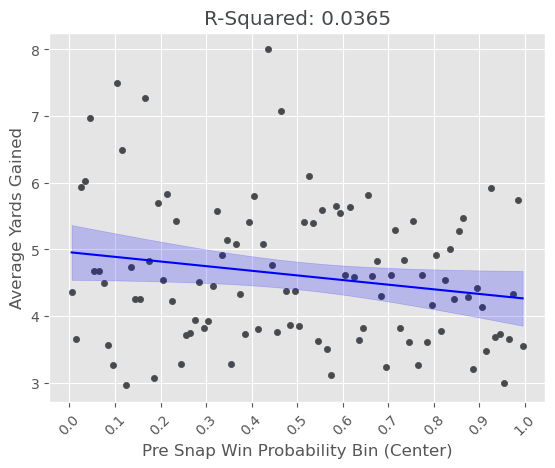

In [14]:
# Bin the win probability by 0.01
df['wp_bin'] = pd.cut(df['pre_snap_wp'], bins=np.arange(0, 1.01, 0.01), include_lowest=True)

# Calculate the average yards gained for each bin
wp_bin_avg = df.groupby('wp_bin').agg({'yards_gained': 'mean'}).reset_index()
wp_bin_avg['bin_center'] = np.arange(0.005, 1.005, 0.01)  # Center of each bin

# Linear regression for best fit line using statsmodels
X = sm.add_constant(wp_bin_avg['bin_center'])  # Add constant for intercept
ols_model = sm.OLS(wp_bin_avg['yards_gained'], X)
est = ols_model.fit()

# Generate predictions and confidence intervals
pred = est.get_prediction(X).summary_frame()

# Plotting
plt.style.use('ggplot')
fig, ax = plt.subplots()

# Scatter plot for average yards gained per bin
ax.scatter(
    wp_bin_avg['bin_center'], 
    wp_bin_avg['yards_gained'], 
    marker='o', 
    color='#474a4d', 
    s=20, 
    label='Binned Average'
)

# Best fit line
y_pred = est.predict(X)
ax.plot(
    wp_bin_avg['bin_center'], 
    y_pred, 
    color='blue', 
    label='Best Fit Line'
)

# Shaded confidence interval
ax.fill_between(
    wp_bin_avg['bin_center'], 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2, 
    label='95% CI'
)

# Plot customization
plt.xlabel('Pre Snap Win Probability Bin (Center)')
plt.ylabel('Average Yards Gained')
plt.title(f'R-Squared: {est.rsquared:.4f}', color='#474a4d')
plt.xticks(ticks=np.arange(0, 1.05, 0.1), rotation=45)
plt.grid(True)
plt.gca().set_axisbelow(True)

df.drop(columns=['wp_bin'], inplace=True)

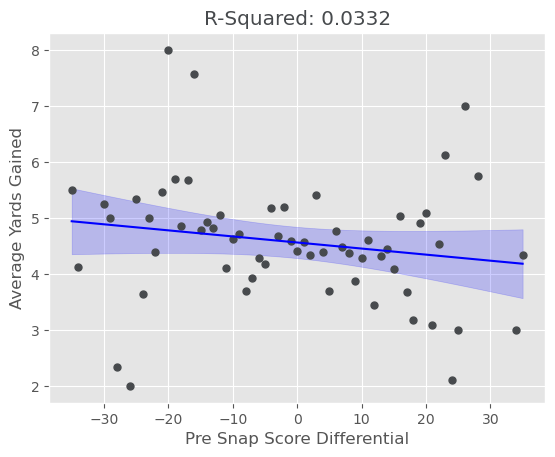

In [15]:
plt.style.use('ggplot')

diff_bin_avg = df.groupby('pre_snap_score_diff').agg({'yards_gained': 'mean'}).reset_index()

# Linear regression for best fit line
X = sm.add_constant(diff_bin_avg['pre_snap_score_diff'])
ols_model = sm.OLS(diff_bin_avg['yards_gained'], X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
diff_bin_avg.plot(x='pre_snap_score_diff',y='yards_gained',linestyle='None', ax=ax, marker='o', color='#474a4d', markersize=5)
y_pred = est.predict(X)
x_pred = diff_bin_avg.pre_snap_score_diff.values
ax.plot(x_pred,y_pred, color='blue')

pred = est.get_prediction(X).summary_frame()

ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2
)

plt.xlabel('Pre Snap Score Differential')
plt.ylabel('Average Yards Gained')
plt.title('R-Squared: {:.4f}'.format(est.rsquared), color='#474a4d')

ax.get_legend().remove()
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

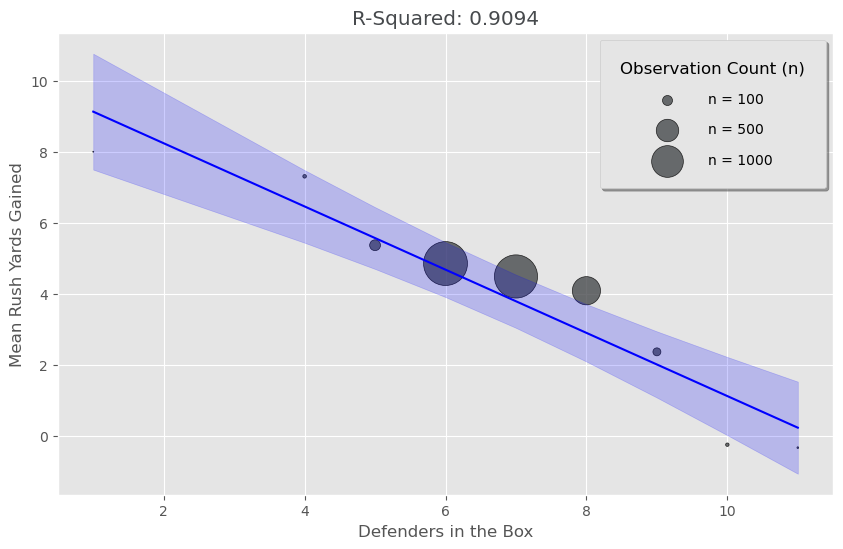

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Calculate the average and count for each group of defenders in the box
avgs = df.groupby('defenders_in_box').agg(
    yards_gained_mean=('yards_gained', 'mean'),
    n=('yards_gained', 'size')
).reset_index()

# Linear regression for best fit line
X = sm.add_constant(avgs['defenders_in_box'])
ols_model = sm.OLS(avgs['yards_gained_mean'], X)
est = ols_model.fit()

# Generate predictions and confidence intervals
pred = est.get_prediction(X).summary_frame()

# Plotting
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))

# Scale marker size based on n (number of observations)
size_scale = 1000  # Adjust for better visualization
marker_sizes = avgs['n'] * size_scale / avgs['n'].max()

# Scatter plot with variable marker sizes
scatter = ax.scatter(
    avgs['defenders_in_box'], 
    avgs['yards_gained_mean'], 
    s=marker_sizes, 
    c='#474a4d', 
    alpha=0.8, 
    edgecolor='black', 
)

# Best fit line
x_pred = avgs['defenders_in_box'].values
y_pred = est.predict(X)
ax.plot(x_pred, y_pred, color='blue')

# Shaded confidence interval
ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2, 
)

# Add a legend for specific values of n
example_ns = [100, 500, 1000]
for example_n in example_ns:
    ax.scatter(
        [], [], 
        s=example_n * size_scale / avgs['n'].max(), 
        c='#474a4d', 
        alpha=0.8, 
        edgecolor='black', 
        label=f"n = {example_n}"
    )

# Customize legend with spacing between lines
legend = plt.legend(
    title='Observation Count (n)', 
    loc='upper right',
    fontsize=10, 
    title_fontsize=12, 
    frameon=True,
    shadow=True,
    handletextpad=2,  # Add spacing between legend text and markers
    borderpad=1.5,    # Add padding around legend box
    labelspacing=1.2  # Add spacing between legend entries
)

# Plot customization
plt.xlabel('Defenders in the Box')
plt.ylabel('Mean Rush Yards Gained')
plt.title(f'R-Squared: {est.rsquared:.4f}', color='#474a4d')
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

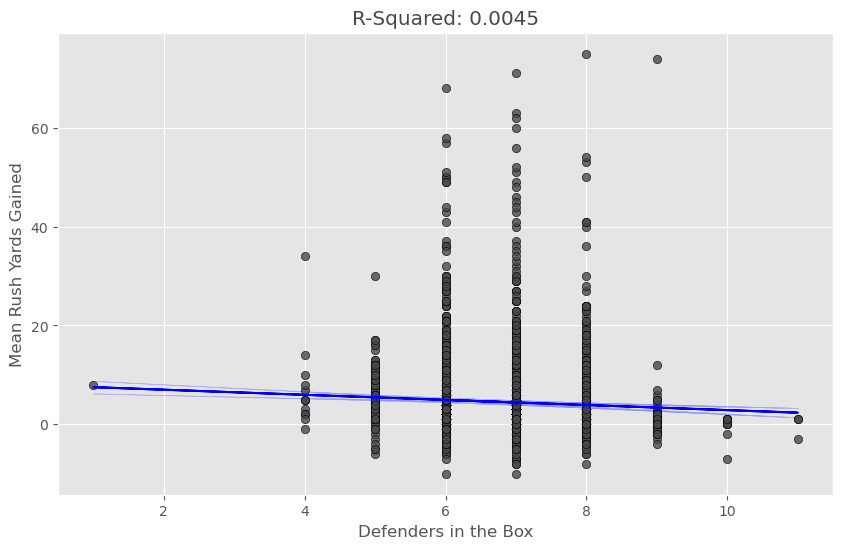

In [17]:
# Linear regression for best fit line
X = sm.add_constant(df['defenders_in_box'])
ols_model = sm.OLS(df['yards_gained'], X)
est = ols_model.fit()

# Generate predictions and confidence intervals
pred = est.get_prediction(X).summary_frame()

# Plotting
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with variable marker sizes
scatter = ax.scatter(
    df['defenders_in_box'], 
    df['yards_gained'], 
    c='#474a4d', 
    alpha=0.8, 
    edgecolor='black', 
)

# Best fit line
x_pred = df['defenders_in_box'].values
y_pred = est.predict(X)
ax.plot(x_pred, y_pred, color='blue')

# Shaded confidence interval
ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2, 
)

# Plot customization
plt.xlabel('Defenders in the Box')
plt.ylabel('Mean Rush Yards Gained')
plt.title(f'R-Squared: {est.rsquared:.4f}', color='#474a4d')
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

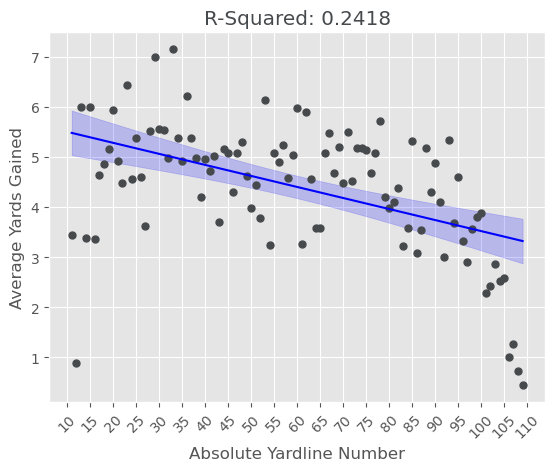

In [18]:
plt.style.use('ggplot')

avg = df.groupby('absolute_yardline_number').agg({'yards_gained': 'mean'}).reset_index()

# Linear regression for best fit line
X = sm.add_constant(avg['absolute_yardline_number'])
ols_model = sm.OLS(avg['yards_gained'], X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
avg.plot(x='absolute_yardline_number',y='yards_gained',linestyle='None', ax=ax, marker='o', color='#474a4d', markersize=5)
y_pred = est.predict(X)
x_pred = avg.absolute_yardline_number.values
ax.plot(x_pred,y_pred, color='blue')

pred = est.get_prediction(X).summary_frame()

ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2
)

plt.xlabel('Absolute Yardline Number')
plt.ylabel('Average Yards Gained')
plt.title('R-Squared: {:.4f}'.format(est.rsquared), color='#474a4d')
plt.xticks(ticks=np.arange(10, 111, 5), rotation=45)

ax.get_legend().remove()
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

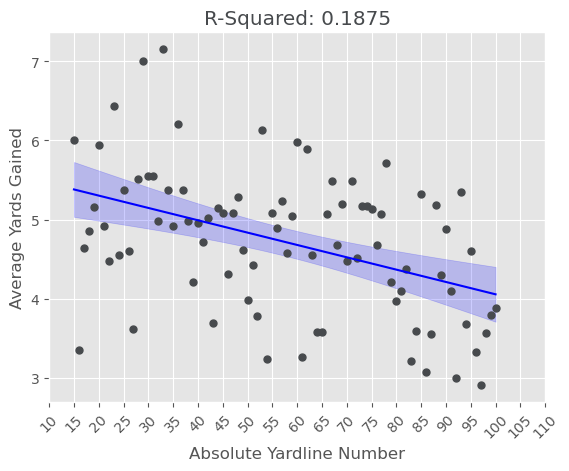

In [19]:
plt.style.use('ggplot')

avg = (
    df
    .query('15 <= absolute_yardline_number <= 100') # filter between 5 and 90 yard lines
    .groupby('absolute_yardline_number')
    .agg({'yards_gained': 'mean'})
    .reset_index()
)

# Linear regression for best fit line
X = sm.add_constant(avg['absolute_yardline_number'])
ols_model = sm.OLS(avg['yards_gained'], X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
avg.plot(x='absolute_yardline_number',y='yards_gained',linestyle='None', ax=ax, marker='o', color='#474a4d', markersize=5)
y_pred = est.predict(X)
x_pred = avg.absolute_yardline_number.values
ax.plot(x_pred,y_pred, color='blue')

pred = est.get_prediction(X).summary_frame()

ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2
)

plt.xlabel('Absolute Yardline Number')
plt.ylabel('Average Yards Gained')
plt.title('R-Squared: {:.4f}'.format(est.rsquared), color='#474a4d')
plt.xticks(ticks=np.arange(10, 111, 5), rotation=45)

ax.get_legend().remove()
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

<Figure size 1200x600 with 0 Axes>

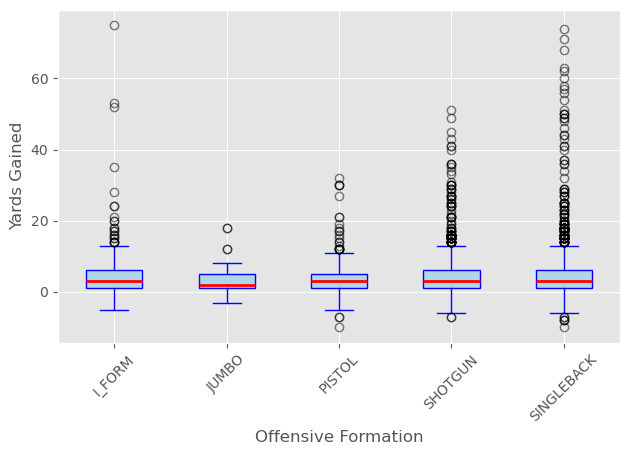

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Generate a boxplot grouped by 'offense_formation' with 'yards_gained' on the y-axis
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
df.boxplot(
    column='yards_gained',
    by='offense_formation',
    grid=False,
    showfliers=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    medianprops=dict(color='red', linewidth=2),
    flierprops=dict(marker='o', color='blue', alpha=0.5)
)
plt.title('')
plt.grid(True)
plt.suptitle('')  # Remove default groupby title
plt.xlabel('Offensive Formation')
plt.ylabel('Yards Gained')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
df.groupby('offense_formation').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

yards_gained  absolute_yardline_number
offense_formation                                        
SHOTGUN                4.690068                 60.045662
SINGLEBACK             4.551898                 57.759031
I_FORM                 4.543897                 57.372591
PISTOL                 3.966463                 61.536585
JUMBO                  3.542857                 65.142857

<Figure size 1200x600 with 0 Axes>

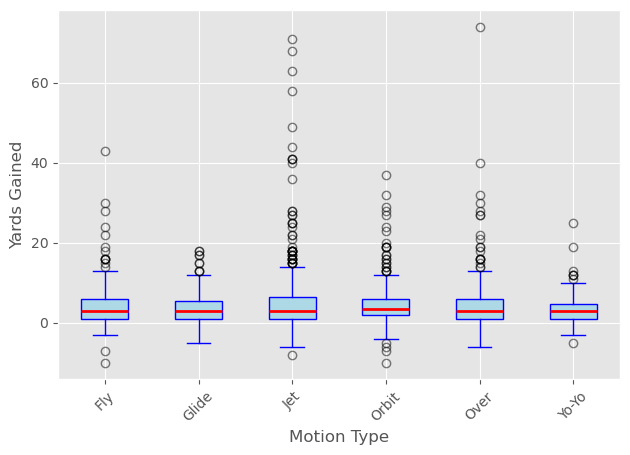

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
df.query('motion_present').boxplot(
    column='yards_gained',
    by='motion_group',
    grid=False,
    showfliers=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    medianprops=dict(color='red', linewidth=2),
    flierprops=dict(marker='o', color='blue', alpha=0.5)
)
plt.title('')
plt.grid(True)
plt.suptitle('')  # Remove default groupby title
plt.xlabel('Motion Type')
plt.ylabel('Yards Gained')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
df.groupby('motion_group').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

yards_gained  absolute_yardline_number
motion_group                                        
Jet               5.092399                 57.886736
Orbit             4.586826                 57.332335
Over              4.546713                 58.775087
Fly               4.420091                 58.287671
Glide             3.892216                 59.089820
Yo-Yo             3.425373                 59.082090

<Figure size 1200x600 with 0 Axes>

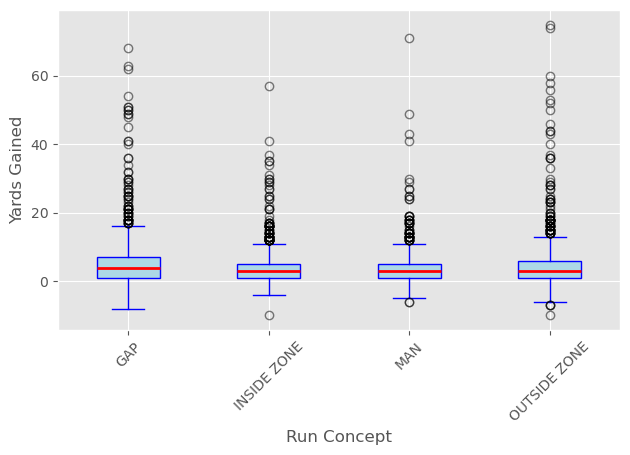

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
df.boxplot(
    column='yards_gained',
    by='run_concept',
    grid=False,
    showfliers=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    medianprops=dict(color='red', linewidth=2),
    flierprops=dict(marker='o', color='blue', alpha=0.5)
)
plt.title('')
plt.grid(True)
plt.suptitle('')  # Remove default groupby title
plt.xlabel('Run Concept')
plt.ylabel('Yards Gained')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
df.groupby('run_concept').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

yards_gained  absolute_yardline_number
run_concept                                         
GAP               5.178881                 58.764381
OUTSIDE ZONE      4.473369                 56.073236
INSIDE ZONE       4.261058                 60.422376
MAN               4.159763                 61.911243

In [26]:
df.groupby('motion_present').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

yards_gained  absolute_yardline_number
motion_present                                        
True                4.597574                 58.173649
False               4.527580                 59.305922

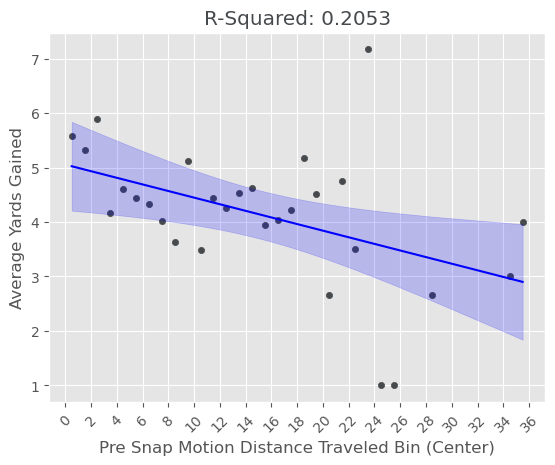

In [27]:
# Bin the win probability by 0.01
df['wp_bin'] = pd.cut(
    df['pre_snap_motion_dist_traveled'], 
    bins=np.arange(
        df['pre_snap_motion_dist_traveled'].min(),
        df['pre_snap_motion_dist_traveled'].max() + 1,
        1
    ),
    include_lowest=True
)

# Calculate the average yards gained for each bin
wp_bin_avg = df.groupby('wp_bin').agg({'yards_gained': 'mean'}).reset_index()
wp_bin_avg['bin_center'] = np.arange(
    df['pre_snap_motion_dist_traveled'].min() + 0.5,
    df['pre_snap_motion_dist_traveled'].max() + 0.5,
    1
)  

# Linear regression for best fit line using statsmodels
X = sm.add_constant(wp_bin_avg['bin_center'])  # Add constant for intercept
ols_model = sm.OLS(wp_bin_avg.loc[~wp_bin_avg['yards_gained'].isna(),'yards_gained'], X[~wp_bin_avg['yards_gained'].isna()])
est = ols_model.fit()

# Generate predictions and confidence intervals
pred = est.get_prediction(X[~wp_bin_avg['yards_gained'].isna()]).summary_frame()

# Plotting
plt.style.use('ggplot')
fig, ax = plt.subplots()

# Scatter plot for average yards gained per bin
ax.scatter(
    wp_bin_avg['bin_center'], 
    wp_bin_avg['yards_gained'], 
    marker='o', 
    color='#474a4d', 
    s=20, 
    label='Binned Average'
)

# Best fit line
y_pred = est.predict(X[~wp_bin_avg['yards_gained'].isna()])
ax.plot(
    wp_bin_avg['bin_center'][~wp_bin_avg['yards_gained'].isna()],
    y_pred, 
    color='blue', 
    label='Best Fit Line'
)

# Shaded confidence interval
ax.fill_between(
    wp_bin_avg.loc[~wp_bin_avg['yards_gained'].isna(),'bin_center'], 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2, 
    label='95% CI'
)

# Plot customization
plt.xlabel('Pre Snap Motion Distance Traveled Bin (Center)')
plt.ylabel('Average Yards Gained')
plt.title(f'R-Squared: {est.rsquared:.4f}', color='#474a4d')
plt.xticks(
    ticks=np.arange(
        df['pre_snap_motion_dist_traveled'].min(),
        df['pre_snap_motion_dist_traveled'].max() + 1,
        2
    ), 
    rotation=45
)
plt.grid(True)
plt.gca().set_axisbelow(True)

df.drop(columns=['wp_bin'], inplace=True)

<Figure size 1200x600 with 0 Axes>

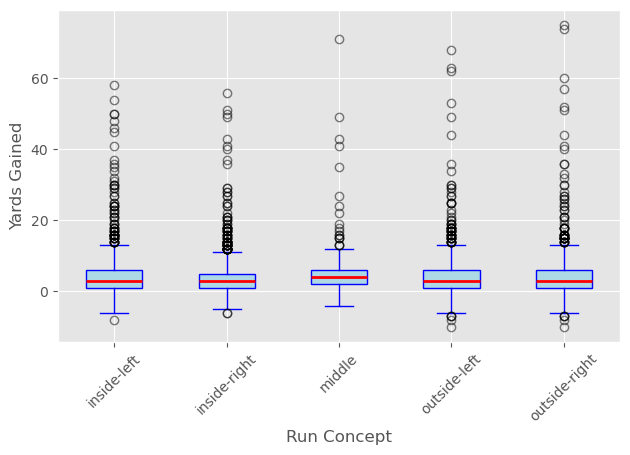

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
df.boxplot(
    column='yards_gained',
    by='play_dir_location',
    grid=False,
    showfliers=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    medianprops=dict(color='red', linewidth=2),
    flierprops=dict(marker='o', color='blue', alpha=0.5)
)
plt.title('')
plt.grid(True)
plt.suptitle('')  # Remove default groupby title
plt.xlabel('Run Concept')
plt.ylabel('Yards Gained')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
df.groupby('play_dir_location').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

yards_gained  absolute_yardline_number
play_dir_location                                        
middle                 5.099237                 58.091603
outside-right          4.670455                 57.139773
inside-left            4.662319                 59.778986
outside-left           4.391039                 58.401222
inside-right           4.369170                 59.626877

In [30]:
df.groupby('down').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

yards_gained  absolute_yardline_number
down                                        
1         4.656796                 57.596861
2         4.440895                 59.491374
3         4.349727                 64.606557
4         3.542857                 73.771429

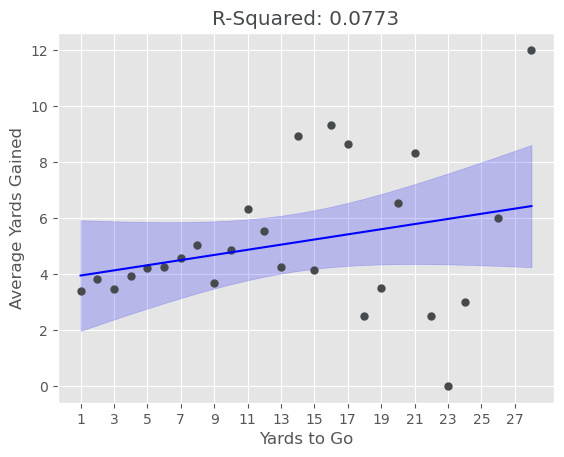

In [31]:
plt.style.use('ggplot')

avg = (
    df
    # .query('15 <= absolute_yardline_number <= 100') # filter between 5 and 90 yard lines
    .groupby('yards_to_go')
    .agg({'yards_gained': 'mean'})
    .reset_index()
)

# Linear regression for best fit line
X = sm.add_constant(avg['yards_to_go'])
ols_model = sm.OLS(avg['yards_gained'], X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
avg.plot(x='yards_to_go',y='yards_gained',linestyle='None', ax=ax, marker='o', color='#474a4d', markersize=5)
y_pred = est.predict(X)
x_pred = avg.yards_to_go.values
ax.plot(x_pred,y_pred, color='blue')

pred = est.get_prediction(X).summary_frame()

ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2
)

plt.xlabel('Yards to Go')
plt.ylabel('Average Yards Gained')
plt.title('R-Squared: {:.4f}'.format(est.rsquared), color='#474a4d')
plt.xticks(
    ticks=np.arange(
        df['yards_to_go'].min(),
        df['yards_to_go'].max() + 1,
        2
    ), 
    rotation=0
)

ax.get_legend().remove()
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

# Model Creation

In [28]:
# filter between 5 and 90 yard lines
df = df.query('15 <= absolute_yardline_number <= 100').reset_index(drop=True)

In [95]:
avg_yards_gained_by_def_in_box = (
    df
    .groupby('defenders_in_box')
    .agg({'yards_gained': 'mean'})
    .reset_index()
)

X = sm.add_constant(avg_yards_gained_by_def_in_box['defenders_in_box'])
ols_model = sm.OLS(avg_yards_gained_by_def_in_box['yards_gained'], X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

# map predicitons ot defenders_in_box
avg_yards_gained_by_def_in_box['y_pred'] = est.predict(X)

df['avg_yards_gained_by_def_in_box'] = df['defenders_in_box'].map(avg_yards_gained_by_def_in_box.set_index('defenders_in_box')['y_pred'])

df['run_loc'] = np.where(
    df.play_dir_location.isin(['outside-right', 'outside-left']),
    'outside',
    np.where(
        df.play_dir_location.isin(['inside-right', 'inside-left']),
        'inside',
        'middle'
    )
)

In [30]:
df.head()

game_play_id  week   run_concept play_dir_location  \
0  2022091105_3712     1  OUTSIDE ZONE      inside-right   
1  2022091104_1094     1  OUTSIDE ZONE     outside-right   
2  2022091101_3923     1   INSIDE ZONE            middle   
3  2022091106_1380     1   INSIDE ZONE      inside-right   
4   2022091100_501     1  OUTSIDE ZONE      outside-left   

   motion_had_rush_attempt  pre_snap_motion_dist_traveled motion_group  \
0                      NaN                            NaN          NaN   
1                      0.0                       0.697350          Jet   
2                      NaN                            NaN          NaN   
3                      0.0                       8.234742        Orbit   
4                      0.0                       9.052830        Orbit   

   motion_present  motion_towards_playside  down  yards_to_go  \
0           False                      NaN     1           10   
1            True                      1.0     1           10   
2           False                      NaN     2           11   
3            True                      1.0     1           10   
4            True                      1.0     1           10   

   absolute_yardline_number offense_formation  defenders_in_box  \
0                        81        SINGLEBACK               6.0   
1                        35        SINGLEBACK               7.0   
2                        95        SINGLEBACK               8.0   
3                        18            I_FORM               7.0   
4                        33        SINGLEBACK               6.0   

   pre_snap_score_diff  pre_snap_wp  yards_gained  off_run_str  def_run_str  \
0                   -7     0.221582            14     1.392318     0.072716   
1                    0     0.395236             1     0.185307     0.570676   
2                   -2     0.741719             0    -0.661687    -0.660546   
3                   10     0.847051             1    -0.984868    -0.440863   
4                   -3     0.618278             5    -0.743286    -0.431273   

   avg_yards_gained_by_def_in_box  run_loc  
0                        4.689824   inside  
1                        3.764743  outside  
2                        2.839662   middle  
3                        3.764743   inside  
4                        4.689824  outside

In [71]:
n_cores = multiprocessing.cpu_count()

df = df.reset_index(drop=True)

# Define features
features = ['absolute_yardline_number', 'avg_yards_gained_by_def_in_box', 'motion_present', 
            'pre_snap_wp', 'yards_to_go', 'down', 'run_concept', 'run_loc', 'offense_formation',
            'motion_group', 'motion_had_rush_attempt', 'pre_snap_motion_dist_traveled', 'motion_towards_playside',
            'off_run_str', 'def_run_str']
X = df[features].copy()
y = df[['yards_gained']].copy()

down_enc = pd.get_dummies(X['down'], prefix='down')
X = pd.concat([X, down_enc], axis=1)
X.drop(columns='down', inplace=True)

# ['OUTSIDE ZONE', 'INSIDE ZONE', 'MAN', 'POWER', 'COUNTER', 'PULL LEAD']
run_concept_enc = pd.get_dummies(X['run_concept'], prefix='run_concept')
X = pd.concat([X, run_concept_enc], axis=1)
X.drop(columns='run_concept', inplace=True)

run_loc_enc = pd.get_dummies(X['run_loc'], prefix='run_loc')
X = pd.concat([X, run_loc_enc], axis=1)
X.drop(columns='run_loc', inplace=True)

# ['SINGLEBACK', 'I_FORM', 'SHOTGUN', 'PISTOL', 'JUMBO']
offensive_formation_enc = pd.get_dummies(X['offense_formation'], prefix='offense_formation')
X = pd.concat([X, offensive_formation_enc], axis=1)
X.drop(columns='offense_formation', inplace=True)

# Create interaction terms between 'yards_to_go' and down variables
X['yards_to_go_down_1'] = X['yards_to_go'] * X['down_1']
X['yards_to_go_down_2'] = X['yards_to_go'] * X['down_2']
X['yards_to_go_down_3'] = X['yards_to_go'] * X['down_3']
X['yards_to_go_down_4'] = X['yards_to_go'] * X['down_4']

# Interaction between 'run_loc' and 'yards_to_go'
X['run_loc_outside_yards_to_go'] = X['run_loc_outside'] * X['yards_to_go']
X['run_loc_inside_yards_to_go'] = X['run_loc_inside'] * X['yards_to_go']
X['run_loc_middle_yards_to_go'] = X['run_loc_middle'] * X['yards_to_go']

# Motion groups: ['None', 'Jet', 'Orbit', 'Yo-Yo', 'Fly', 'Glide', 'Over']
X['motion_group'] = X['motion_group'].replace(np.nan, 'None')
motion_group_enc = pd.get_dummies(X['motion_group'], prefix='motion_group')
X = pd.concat([X, motion_group_enc], axis=1)

# Create Interaction terms between 'motion_group' and 'run_concept'
# Jet Motions
X['outside_zone_run_concept_with_jet_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Jet']
X['inside_zone_run_concept_with_jet_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Jet']
X['power_run_concept_with_jet_motion'] = X['run_concept_POWER'] * X['motion_group_Jet']
X['counter_run_concept_with_jet_motion'] = X['run_concept_COUNTER'] * X['motion_group_Jet']
X['pull_lead_run_concept_with_jet_motion'] = X['run_concept_PULL LEAD'] * X['motion_group_Jet']
X['man_run_concept_with_jet_motion'] = X['run_concept_MAN'] * X['motion_group_Jet']
# Orbit Motions
X['outside_zone_run_concept_with_orbit_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Orbit']
X['inside_zone_run_concept_with_orbit_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Orbit']
X['power_run_concept_with_orbit_motion'] = X['run_concept_POWER'] * X['motion_group_Orbit']
X['counter_run_concept_with_orbit_motion'] = X['run_concept_COUNTER'] * X['motion_group_Orbit']
X['pull_lead_run_concept_with_orbit_motion'] = X['run_concept_PULL LEAD'] * X['motion_group_Orbit']
X['man_run_concept_with_orbit_motion'] = X['run_concept_MAN'] * X['motion_group_Orbit']
# Yo-Yo Motions
X['outside_zone_run_concept_with_yo_yo_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Yo-Yo']
X['inside_zone_run_concept_with_yo_yo_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Yo-Yo']
X['power_run_concept_with_yo_yo_motion'] = X['run_concept_POWER'] * X['motion_group_Yo-Yo']
X['counter_run_concept_with_yo_yo_motion'] = X['run_concept_COUNTER'] * X['motion_group_Yo-Yo']
X['pull_lead_run_concept_with_yo_yo_motion'] = X['run_concept_PULL LEAD'] * X['motion_group_Yo-Yo']
X['man_run_concept_with_yo_yo_motion'] = X['run_concept_MAN'] * X['motion_group_Yo-Yo']
# Fly Motions
X['outside_zone_run_concept_with_fly_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Fly']
X['inside_zone_run_concept_with_fly_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Fly']
X['power_run_concept_with_fly_motion'] = X['run_concept_POWER'] * X['motion_group_Fly']
X['counter_run_concept_with_fly_motion'] = X['run_concept_COUNTER'] * X['motion_group_Fly']
X['pull_lead_run_concept_with_fly_motion'] = X['run_concept_PULL LEAD'] * X['motion_group_Fly']
X['man_run_concept_with_fly_motion'] = X['run_concept_MAN'] * X['motion_group_Fly']                                                                            
# Glide Motions
X['outside_zone_run_concept_with_glide_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Glide']
X['inside_zone_run_concept_with_glide_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Glide']
X['power_run_concept_with_glide_motion'] = X['run_concept_POWER'] * X['motion_group_Glide']
X['counter_run_concept_with_glide_motion'] = X['run_concept_COUNTER'] * X['motion_group_Glide']
X['pull_lead_run_concept_with_glide_motion'] = X['run_concept_PULL LEAD'] * X['motion_group_Glide']
X['man_run_concept_with_glide_motion'] = X['run_concept_MAN'] * X['motion_group_Glide']
# Over Motions
X['outside_zone_run_concept_with_over_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Over']
X['inside_zone_run_concept_with_over_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Over']
X['power_run_concept_with_over_motion'] = X['run_concept_POWER'] * X['motion_group_Over']
X['counter_run_concept_with_over_motion'] = X['run_concept_COUNTER'] * X['motion_group_Over']
X['pull_lead_run_concept_with_over_motion'] = X['run_concept_PULL LEAD'] * X['motion_group_Over']
X['man_run_concept_with_over_motion'] = X['run_concept_MAN'] * X['motion_group_Over']

# Fill missing values in 'motion_had_rush_attempt' with 0
X['motion_had_rush_attempt'] = X['motion_had_rush_attempt'].fillna(0).astype(int)

# Encode 'motion_towards_playside' as binary
X['motion_towards_playside'] = X['motion_towards_playside'] == 1
X['motion_towards_backside'] = X['motion_towards_playside'] == -1
# X['motion_on_middle_run'] = X['motion_towards_playside'] == 0

# Interaction terms between 'motion_towards_playside' and 'motion_group'
X['motion_towards_playside_on_jet'] = X['motion_towards_playside'] * X['motion_group_Jet']
X['motion_towards_playside_on_orbit'] = X['motion_towards_playside'] * X['motion_group_Orbit']
X['motion_towards_playside_on_yo_yo'] = X['motion_towards_playside'] * X['motion_group_Yo-Yo']
X['motion_towards_playside_on_fly'] = X['motion_towards_playside'] * X['motion_group_Fly']
X['motion_towards_playside_on_glide'] = X['motion_towards_playside'] * X['motion_group_Glide']
X['motion_towards_playside_on_over'] = X['motion_towards_playside'] * X['motion_group_Over']
X['motion_towards_backside_on_jet'] = X['motion_towards_backside'] * X['motion_group_Jet']
X['motion_towards_backside_on_orbit'] = X['motion_towards_backside'] * X['motion_group_Orbit']
X['motion_towards_backside_on_yo_yo'] = X['motion_towards_backside'] * X['motion_group_Yo-Yo']
X['motion_towards_backside_on_fly'] = X['motion_towards_backside'] * X['motion_group_Fly']
X['motion_towards_backside_on_glide'] = X['motion_towards_backside'] * X['motion_group_Glide']
X['motion_towards_backside_on_over'] = X['motion_towards_backside'] * X['motion_group_Over']

# Fill missing values in 'pre_snap_motion_dist_traveled' with 0
X['pre_snap_motion_dist_traveled'] = X['pre_snap_motion_dist_traveled'].fillna(0)

# Bayesian model
with pm.Model() as model:

    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Absolute yardline number
    yardline_coeff = pm.Normal('yardline', mu=0, sigma=1)

    # Average yards gained by defenders in the box
    defenders_in_box_coeff = pm.Normal('avg_yards_gained_by_def_in_box', mu=0, sigma=1)

    # Pre snap win probability
    pre_snap_wp_coeff = pm.Normal('pre_snap_wp', mu=0, sigma=1)

    # Down coefficients
    down_1_coeff = pm.Normal('down_1', mu=0, sigma=1)
    down_2_coeff = pm.Normal('down_2', mu=0, sigma=1)
    down_3_coeff = pm.Normal('down_3', mu=0, sigma=1)
    down_4_coeff = pm.Normal('down_4', mu=0, sigma=1)

    # Yards to go for first down
    yards_to_go_coeff = pm.Normal('yards_to_go', mu=0, sigma=1)

    # Yards to go interaction with down
    yards_to_go_down_1_coeff = pm.Normal('yards_to_go_down_1', mu=0, sigma=1)
    yards_to_go_down_2_coeff = pm.Normal('yards_to_go_down_2', mu=0, sigma=1)
    yards_to_go_down_3_coeff = pm.Normal('yards_to_go_down_3', mu=0, sigma=1)
    yards_to_go_down_4_coeff = pm.Normal('yards_to_go_down_4', mu=0, sigma=1)

    # Run concepts
    outside_zone_run_concept_coeff = pm.Normal('run_concept_OUTSIDE ZONE', mu=0, sigma=1)
    inside_zone_run_concept_coeff = pm.Normal('run_concept_INSIDE ZONE', mu=0, sigma=1)
    power_run_concept_coeff = pm.Normal('run_concept_POWER', mu=0, sigma=1)
    counter_run_concept_coeff = pm.Normal('run_concept_COUNTER', mu=0, sigma=1)
    pull_lead_run_concept_coeff = pm.Normal('run_concept_PULL LEAD', mu=0, sigma=1)
    man_run_concept_coeff = pm.Normal('run_concept_MAN', mu=0, sigma=1)

    # Run location
    run_loc_outside = pm.Normal('run_loc_outside', mu=0, sigma=1)
    run_loc_inside = pm.Normal('run_loc_inside', mu=0, sigma=1)
    run_loc_middle = pm.Normal('run_loc_middle', mu=0, sigma=1)

    # Run location interaction with yards to go
    run_loc_outside_yards_to_go = pm.Normal('run_loc_outside_yards_to_go', mu=0, sigma=1)
    run_loc_inside_yards_to_go = pm.Normal('run_loc_inside_yards_to_go', mu=0, sigma=1)
    run_loc_middle_yards_to_go = pm.Normal('run_loc_middle_yards_to_go', mu=0, sigma=1)

    # Offensive formations
    off_formation_SINGLEBACK = pm.Normal('offense_formation_SINGLEBACK', mu=0, sigma=1)
    off_formation_I_FORM = pm.Normal('offense_formation_I_FORM', mu=0, sigma=1)
    off_formation_SHOTGUN = pm.Normal('offense_formation_SHOTGUN', mu=0, sigma=1)
    off_formation_PISTOL = pm.Normal('offense_formation_PISTOL', mu=0, sigma=1)
    off_formation_JUMBO = pm.Normal('offense_formation_JUMBO', mu=0, sigma=1)

    # Motion groups
    motion_group_Jet = pm.Normal('motion_group_Jet', mu=0, sigma=1)
    motion_group_Orbit = pm.Normal('motion_group_Orbit', mu=0, sigma=1)
    motion_group_Yo_Yo = pm.Normal('motion_group_Yo_Yo', mu=0, sigma=1)
    motion_group_Fly = pm.Normal('motion_group_Fly', mu=0, sigma=1)
    motion_group_Glide = pm.Normal('motion_group_Glide', mu=0, sigma=1)
    motion_group_Over = pm.Normal('motion_group_Over', mu=0, sigma=1)
    
    # Jet motion interaction with run concepts
    outside_zone_run_concept_with_jet_motion_coeff = pm.Normal('outside_zone_run_concept_with_jet_motion', mu=0, sigma=1)
    inside_zone_run_concept_with_jet_motion_coeff = pm.Normal('inside_zone_run_concept_with_jet_motion',mu=0, sigma=1)
    power_run_concept_with_jet_motion_coeff = pm.Normal('power_run_concept_with_jet_motion',mu=0, sigma=1)
    counter_run_concept_with_jet_motion_coeff = pm.Normal('counter_run_concept_with_jet_motion',mu=0, sigma=1)
    pull_lead_run_concept_with_jet_motion_coeff = pm.Normal('pull_lead_run_concept_with_jet_motion',mu=0, sigma=1)
    man_run_concept_with_jet_motion_coeff = pm.Normal('man_run_concept_with_jet_motion',mu=0, sigma=1)

    # Orbit motion interaction with run concepts
    outside_zone_run_concept_with_orbit_motion_coeff = pm.Normal('outside_zone_run_concept_with_orbit_motion',mu=0, sigma=1)
    inside_zone_run_concept_with_orbit_motion_coeff = pm.Normal('inside_zone_run_concept_with_orbit_motion',mu=0, sigma=1)
    power_run_concept_with_orbit_motion_coeff = pm.Normal('power_run_concept_with_orbit_motion',mu=0, sigma=1)
    counter_run_concept_with_orbit_motion_coeff = pm.Normal('counter_run_concept_with_orbit_motion',mu=0, sigma=1)
    pull_lead_run_concept_with_orbit_motion_coeff = pm.Normal('pull_lead_run_concept_with_orbit_motion',mu=0, sigma=1)
    man_run_concept_with_orbit_motion_coeff = pm.Normal('man_run_concept_with_orbit_motion',mu=0, sigma=1)

    # Yo-Yo motion interaction with run concepts
    outside_zone_run_concept_with_yo_yo_motion_coeff = pm.Normal('outside_zone_run_concept_with_yo_yo_motion',mu=0, sigma=1)
    inside_zone_run_concept_with_yo_yo_motion_coeff = pm.Normal('inside_zone_run_concept_with_yo_yo_motion',mu=0, sigma=1)
    power_run_concept_with_yo_yo_motion_coeff = pm.Normal('power_run_concept_with_yo_yo_motion',mu=0, sigma=1)
    counter_run_concept_with_yo_yo_motion_coeff = pm.Normal('counter_run_concept_with_yo_yo_motion',mu=0, sigma=1)
    pull_lead_run_concept_with_yo_yo_motion_coeff = pm.Normal('pull_lead_run_concept_with_yo_yo_motion',mu=0, sigma=1)
    man_run_concept_with_yo_yo_motion_coeff = pm.Normal('man_run_concept_with_yo_yo_motion',mu=0, sigma=1)

    # Fly motion interaction with run concepts
    outside_zone_run_concept_with_fly_motion_coeff = pm.Normal('outside_zone_run_concept_with_fly_motion',mu=0, sigma=1)
    inside_zone_run_concept_with_fly_motion_coeff = pm.Normal('inside_zone_run_concept_with_fly_motion',mu=0, sigma=1)
    power_run_concept_with_fly_motion_coeff = pm.Normal('power_run_concept_with_fly_motion',mu=0, sigma=1)
    counter_run_concept_with_fly_motion_coeff = pm.Normal('counter_run_concept_with_fly_motion',mu=0, sigma=1)
    pull_lead_run_concept_with_fly_motion_coeff = pm.Normal('pull_lead_run_concept_with_fly_motion',mu=0, sigma=1)
    man_run_concept_with_fly_motion_coeff = pm.Normal('man_run_concept_with_fly_motion',mu=0, sigma=1)

    # Glide motion interaction with run concepts
    outside_zone_run_concept_with_glide_motion_coeff = pm.Normal('outside_zone_run_concept_with_glide_motion',mu=0, sigma=1)
    inside_zone_run_concept_with_glide_motion_coeff = pm.Normal('inside_zone_run_concept_with_glide_motion',mu=0, sigma=1)
    power_run_concept_with_glide_motion_coeff = pm.Normal('power_run_concept_with_glide_motion',mu=0, sigma=1)
    counter_run_concept_with_glide_motion_coeff = pm.Normal('counter_run_concept_with_glide_motion',mu=0, sigma=1)
    pull_lead_run_concept_with_glide_motion_coeff = pm.Normal('pull_lead_run_concept_with_glide_motion',mu=0, sigma=1)
    man_run_concept_with_glide_motion_coeff = pm.Normal('man_run_concept_with_glide_motion',mu=0, sigma=1)

    # Over motion interaction with run concepts
    outside_zone_run_concept_with_over_motion_coeff = pm.Normal('outside_zone_run_concept_with_over_motion',mu=0, sigma=1)
    inside_zone_run_concept_with_over_motion_coeff = pm.Normal('inside_zone_run_concept_with_over_motion',mu=0, sigma=1)
    power_run_concept_with_over_motion_coeff = pm.Normal('power_run_concept_with_over_motion',mu=0, sigma=1)
    counter_run_concept_with_over_motion_coeff = pm.Normal('counter_run_concept_with_over_motion',mu=0, sigma=1)
    pull_lead_run_concept_with_over_motion_coeff = pm.Normal('pull_lead_run_concept_with_over_motion',mu=0, sigma=1)
    man_run_concept_with_over_motion_coeff = pm.Normal('man_run_concept_with_over_motion',mu=0, sigma=1)

    # Motion had rush attempt
    motion_had_rush_attempt_coeff = pm.Normal('motion_had_rush_attempt', mu=0, sigma=1)

    # Interaction betweeen motion direction and motion type
    motion_towards_playside_on_jet = pm.Normal('motion_towards_playside_on_jet', mu=0, sigma=1)
    motion_towards_playside_on_orbit = pm.Normal('motion_towards_playside_on_orbit', mu=0, sigma=1)
    motion_towards_playside_on_yo_yo = pm.Normal('motion_towards_playside_on_yo_yo', mu=0, sigma=1)
    motion_towards_playside_on_fly = pm.Normal('motion_towards_playside_on_fly', mu=0, sigma=1)
    motion_towards_playside_on_glide = pm.Normal('motion_towards_playside_on_glide', mu=0, sigma=1)
    motion_towards_playside_on_over = pm.Normal('motion_towards_playside_on_over', mu=0, sigma=1)
    motion_towards_backside_on_jet = pm.Normal('motion_towards_backside_on_jet', mu=0, sigma=1)
    motion_towards_backside_on_orbit = pm.Normal('motion_towards_backside_on_orbit', mu=0, sigma=1)
    motion_towards_backside_on_yo_yo = pm.Normal('motion_towards_backside_on_yo_yo', mu=0, sigma=1)
    motion_towards_backside_on_fly = pm.Normal('motion_towards_backside_on_fly', mu=0, sigma=1)
    motion_towards_backside_on_glide = pm.Normal('motion_towards_backside_on_glide', mu=0, sigma=1)
    motion_towards_backside_on_over = pm.Normal('motion_towards_backside_on_over', mu=0, sigma=1)

    # Pre snap motion distance traveled
    pre_snap_motion_dist_traveled_coeff = pm.Normal('pre_snap_motion_dist_traveled', mu=0, sigma=1)

    # Offensive Run Grade Prev 10 Games
    off_run_strength_prev_10_games = pm.Normal('off_run_strength_prev_10_games', mu=0, sigma=1)

    # Defensive Run Grade Prev 10 Games
    def_run_strength_prev_10_games = pm.Normal('def_run_strength_prev_10_games', mu=0, sigma=1)
       
    mu = (
        intercept + 
        yardline_coeff * X['absolute_yardline_number'] +
        defenders_in_box_coeff * X['avg_yards_gained_by_def_in_box'] +
        pre_snap_wp_coeff * X['pre_snap_wp'] +

        # Down coefficients
        down_1_coeff * X['down_1'] +
        down_2_coeff * X['down_2'] +
        down_3_coeff * X['down_3'] +
        down_4_coeff * X['down_4'] +

        # Yards to go for first down
        yards_to_go_coeff * X['yards_to_go'] +

        # Yards to go interaction with down
        yards_to_go_down_1_coeff * X['yards_to_go_down_1'] +
        yards_to_go_down_2_coeff * X['yards_to_go_down_2'] +
        yards_to_go_down_3_coeff * X['yards_to_go_down_3'] +
        yards_to_go_down_4_coeff * X['yards_to_go_down_4'] +

        # Run concepts
        outside_zone_run_concept_coeff * X['run_concept_OUTSIDE ZONE'] +
        inside_zone_run_concept_coeff * X['run_concept_INSIDE ZONE'] +
        power_run_concept_coeff * X['run_concept_POWER'] +
        counter_run_concept_coeff * X['run_concept_COUNTER'] +
        pull_lead_run_concept_coeff * X['run_concept_PULL LEAD'] +
        man_run_concept_coeff * X['run_concept_MAN'] +

        # Run location
        run_loc_outside * X['run_loc_outside'] +
        run_loc_inside * X['run_loc_inside'] +
        run_loc_middle * X['run_loc_middle'] +

        # run location interaction with yards to go
        run_loc_outside_yards_to_go * X['run_loc_outside_yards_to_go'] +
        run_loc_inside_yards_to_go * X['run_loc_inside_yards_to_go'] +
        run_loc_middle_yards_to_go * X['run_loc_middle_yards_to_go'] +

        # Offensive formations
        off_formation_SINGLEBACK * X['offense_formation_SINGLEBACK'] +
        off_formation_I_FORM * X['offense_formation_I_FORM'] +
        off_formation_SHOTGUN * X['offense_formation_SHOTGUN'] +
        off_formation_PISTOL * X['offense_formation_PISTOL'] +
        off_formation_JUMBO * X['offense_formation_JUMBO'] +

        # Motion groups
        motion_group_Jet * X['motion_group_Jet'] +
        motion_group_Orbit * X['motion_group_Orbit'] +
        motion_group_Yo_Yo * X['motion_group_Yo-Yo'] +
        motion_group_Fly * X['motion_group_Fly'] +
        motion_group_Glide * X['motion_group_Glide'] +
        motion_group_Over * X['motion_group_Over'] +

        # Jet motion interaction with run concepts
        outside_zone_run_concept_with_jet_motion_coeff * X['outside_zone_run_concept_with_jet_motion'] +
        inside_zone_run_concept_with_jet_motion_coeff * X['inside_zone_run_concept_with_jet_motion'] +
        power_run_concept_with_jet_motion_coeff * X['power_run_concept_with_jet_motion'] +
        counter_run_concept_with_jet_motion_coeff * X['counter_run_concept_with_jet_motion'] +
        pull_lead_run_concept_with_jet_motion_coeff * X['pull_lead_run_concept_with_jet_motion'] +
        man_run_concept_with_jet_motion_coeff * X['man_run_concept_with_jet_motion'] +

        # Orbit motion interaction with run concepts
        outside_zone_run_concept_with_orbit_motion_coeff * X['outside_zone_run_concept_with_orbit_motion'] +
        inside_zone_run_concept_with_orbit_motion_coeff * X['inside_zone_run_concept_with_orbit_motion'] +
        power_run_concept_with_orbit_motion_coeff * X['power_run_concept_with_orbit_motion'] +
        counter_run_concept_with_orbit_motion_coeff * X['counter_run_concept_with_orbit_motion'] +
        pull_lead_run_concept_with_orbit_motion_coeff * X['pull_lead_run_concept_with_orbit_motion'] +
        man_run_concept_with_orbit_motion_coeff * X['man_run_concept_with_orbit_motion'] +

        # Yo-Yo motion interaction with run concepts
        outside_zone_run_concept_with_yo_yo_motion_coeff * X['outside_zone_run_concept_with_yo_yo_motion'] +
        inside_zone_run_concept_with_yo_yo_motion_coeff * X['inside_zone_run_concept_with_yo_yo_motion'] +
        power_run_concept_with_yo_yo_motion_coeff * X['power_run_concept_with_yo_yo_motion'] +
        counter_run_concept_with_yo_yo_motion_coeff * X['counter_run_concept_with_yo_yo_motion'] +
        pull_lead_run_concept_with_yo_yo_motion_coeff * X['pull_lead_run_concept_with_yo_yo_motion'] +
        man_run_concept_with_yo_yo_motion_coeff * X['man_run_concept_with_yo_yo_motion'] +

        # Fly motion interaction with run concepts
        outside_zone_run_concept_with_fly_motion_coeff * X['outside_zone_run_concept_with_fly_motion'] +
        inside_zone_run_concept_with_fly_motion_coeff * X['inside_zone_run_concept_with_fly_motion'] +
        power_run_concept_with_fly_motion_coeff * X['power_run_concept_with_fly_motion'] +
        counter_run_concept_with_fly_motion_coeff * X['counter_run_concept_with_fly_motion'] +
        pull_lead_run_concept_with_fly_motion_coeff * X['pull_lead_run_concept_with_fly_motion'] +
        man_run_concept_with_fly_motion_coeff * X['man_run_concept_with_fly_motion'] +

        # Glide motion interaction with run concepts
        outside_zone_run_concept_with_glide_motion_coeff * X['outside_zone_run_concept_with_glide_motion'] +
        inside_zone_run_concept_with_glide_motion_coeff * X['inside_zone_run_concept_with_glide_motion'] +
        power_run_concept_with_glide_motion_coeff * X['power_run_concept_with_glide_motion'] +
        counter_run_concept_with_glide_motion_coeff * X['counter_run_concept_with_glide_motion'] +
        pull_lead_run_concept_with_glide_motion_coeff * X['pull_lead_run_concept_with_glide_motion'] +
        man_run_concept_with_glide_motion_coeff * X['man_run_concept_with_glide_motion'] +

        # Over motion interaction with run concepts
        outside_zone_run_concept_with_over_motion_coeff * X['outside_zone_run_concept_with_over_motion'] +
        inside_zone_run_concept_with_over_motion_coeff * X['inside_zone_run_concept_with_over_motion'] +
        power_run_concept_with_over_motion_coeff * X['power_run_concept_with_over_motion'] +
        counter_run_concept_with_over_motion_coeff * X['counter_run_concept_with_over_motion'] +
        pull_lead_run_concept_with_over_motion_coeff * X['pull_lead_run_concept_with_over_motion'] +
        man_run_concept_with_over_motion_coeff * X['man_run_concept_with_over_motion'] +

        # Motion had rush attempt
        motion_had_rush_attempt_coeff * X['motion_had_rush_attempt'] +

        # Motion towards/away from playside interaction with motion group
        motion_towards_playside_on_jet * X['motion_towards_playside_on_jet'] +
        motion_towards_playside_on_orbit * X['motion_towards_playside_on_orbit'] +
        motion_towards_playside_on_yo_yo * X['motion_towards_playside_on_yo_yo'] +
        motion_towards_playside_on_fly * X['motion_towards_playside_on_fly'] +
        motion_towards_playside_on_glide * X['motion_towards_playside_on_glide'] +
        motion_towards_playside_on_over * X['motion_towards_playside_on_over'] +
        motion_towards_backside_on_jet * X['motion_towards_backside_on_jet'] +
        motion_towards_backside_on_orbit * X['motion_towards_backside_on_orbit'] +
        motion_towards_backside_on_yo_yo * X['motion_towards_backside_on_yo_yo'] +
        motion_towards_backside_on_fly * X['motion_towards_backside_on_fly'] +
        motion_towards_backside_on_glide * X['motion_towards_backside_on_glide'] +
        motion_towards_backside_on_over * X['motion_towards_backside_on_over'] +

        # Pre snap motion distance traveled
        pre_snap_motion_dist_traveled_coeff * X['pre_snap_motion_dist_traveled'] +

        # Offensive Run Grade Prev 10 Games
        off_run_strength_prev_10_games * X['off_run_str'] +

        # Defensive Run Grade Prev 10 Games
        def_run_strength_prev_10_games * X['def_run_str']
    )

    # Model rush yards as a normal distribution with log-transformed yards
    sigma = pm.HalfNormal('sigma', sigma=1)
    yp = pm.Normal('yards_gained', mu=mu, sigma=sigma, observed=y['yards_gained'])

    # Sample
    trace = pm.sample_smc(
        draws=3000,  # Number of posterior samples
        return_inferencedata=True,  # Return results as an ArviZ InferenceData object
        idata_kwargs={'log_likelihood': True},  # Include log likelihood
        chains=4,  # Number of independent chains
        cores=n_cores,  # Number of CPU cores to use
        parallel=True,  # Use multiple CPU cores
        progressbar=True  # Show progress bar during sampling
    )

# Summarize results
az.summary(trace)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


mean     sd  hdi_3%  hdi_97%  \
intercept                                   1.630  0.782   0.242    3.188   
yardline                                   -0.013  0.005  -0.022   -0.005   
avg_yards_gained_by_def_in_box              0.347  0.136   0.089    0.600   
pre_snap_wp                                -0.338  0.336  -0.943    0.317   
down_1                                      0.265  0.814  -1.279    1.767   
down_2                                      0.846  0.618  -0.292    2.002   
down_3                                      0.172  0.648  -1.050    1.380   
down_4                                      0.354  0.855  -1.223    1.996   
yards_to_go                                 0.130  0.608  -0.994    1.279   
yards_to_go_down_1                         -0.021  0.486  -0.911    0.909   
yards_to_go_down_2                         -0.085  0.486  -0.964    0.866   
yards_to_go_down_3                          0.118  0.488  -0.798    1.039   
yards_to_go_down_4                          0.089  0.798  -1.333    1.649   
run_concept_OUTSIDE ZONE                    0.141  0.449  -0.700    0.962   
run_concept_INSIDE ZONE                    -0.264  0.450  -1.100    0.593   
run_concept_POWER                           0.915  0.494  -0.017    1.842   
run_concept_COUNTER                         0.505  0.515  -0.442    1.496   
run_concept_PULL LEAD                       0.567  0.506  -0.426    1.473   
run_concept_MAN                            -0.200  0.466  -1.030    0.718   
run_loc_outside                             0.430  0.655  -0.824    1.640   
run_loc_inside                              0.886  0.636  -0.308    2.071   
run_loc_middle                              0.304  0.802  -1.240    1.783   
run_loc_outside_yards_to_go                 0.001  0.508  -0.953    0.963   
run_loc_inside_yards_to_go                 -0.008  0.506  -0.982    0.929   
run_loc_middle_yards_to_go                  0.135  0.509  -0.748    1.154   
offense_formation_SINGLEBACK                0.432  0.471  -0.442    1.314   
offense_formation_I_FORM                    0.761  0.511  -0.210    1.705   
offense_formation_SHOTGUN                   0.540  0.492  -0.383    1.460   
offense_formation_PISTOL                   -0.233  0.531  -1.225    0.768   
offense_formation_JUMBO                     0.105  0.787  -1.370    1.570   
motion_group_Jet                            0.575  0.494  -0.393    1.463   
motion_group_Orbit                          0.267  0.558  -0.766    1.325   
motion_group_Yo_Yo                         -0.239  0.693  -1.520    1.064   
motion_group_Fly                            0.443  0.641  -0.776    1.621   
motion_group_Glide                         -0.245  0.607  -1.365    0.909   
motion_group_Over                           0.239  0.607  -0.863    1.417   
outside_zone_run_concept_with_jet_motion   -0.260  0.559  -1.354    0.756   
inside_zone_run_concept_with_jet_motion     0.316  0.611  -0.868    1.412   
power_run_concept_with_jet_motion          -0.314  0.717  -1.692    1.002   
counter_run_concept_with_jet_motion         0.448  0.783  -1.022    1.923   
pull_lead_run_concept_with_jet_motion       0.297  0.717  -1.089    1.616   
man_run_concept_with_jet_motion             0.120  0.669  -1.119    1.403   
outside_zone_run_concept_with_orbit_motion -0.126  0.647  -1.332    1.104   
inside_zone_run_concept_with_orbit_motion   0.459  0.703  -0.823    1.808   
power_run_concept_with_orbit_motion        -0.181  0.845  -1.749    1.433   
counter_run_concept_with_orbit_motion      -0.179  0.820  -1.754    1.319   
pull_lead_run_concept_with_orbit_motion    -0.856  0.784  -2.325    0.643   
man_run_concept_with_orbit_motion           1.145  0.742  -0.247    2.538   
outside_zone_run_concept_with_yo_yo_motion -0.151  0.794  -1.637    1.315   
inside_zone_run_concept_with_yo_yo_motion   0.180  0.793  -1.299    1.672   
power_run_concept_with_yo_yo_motion         0.088  0.912  -1.630    1.804   
counter_run_concept_with_yo_yo_motion    

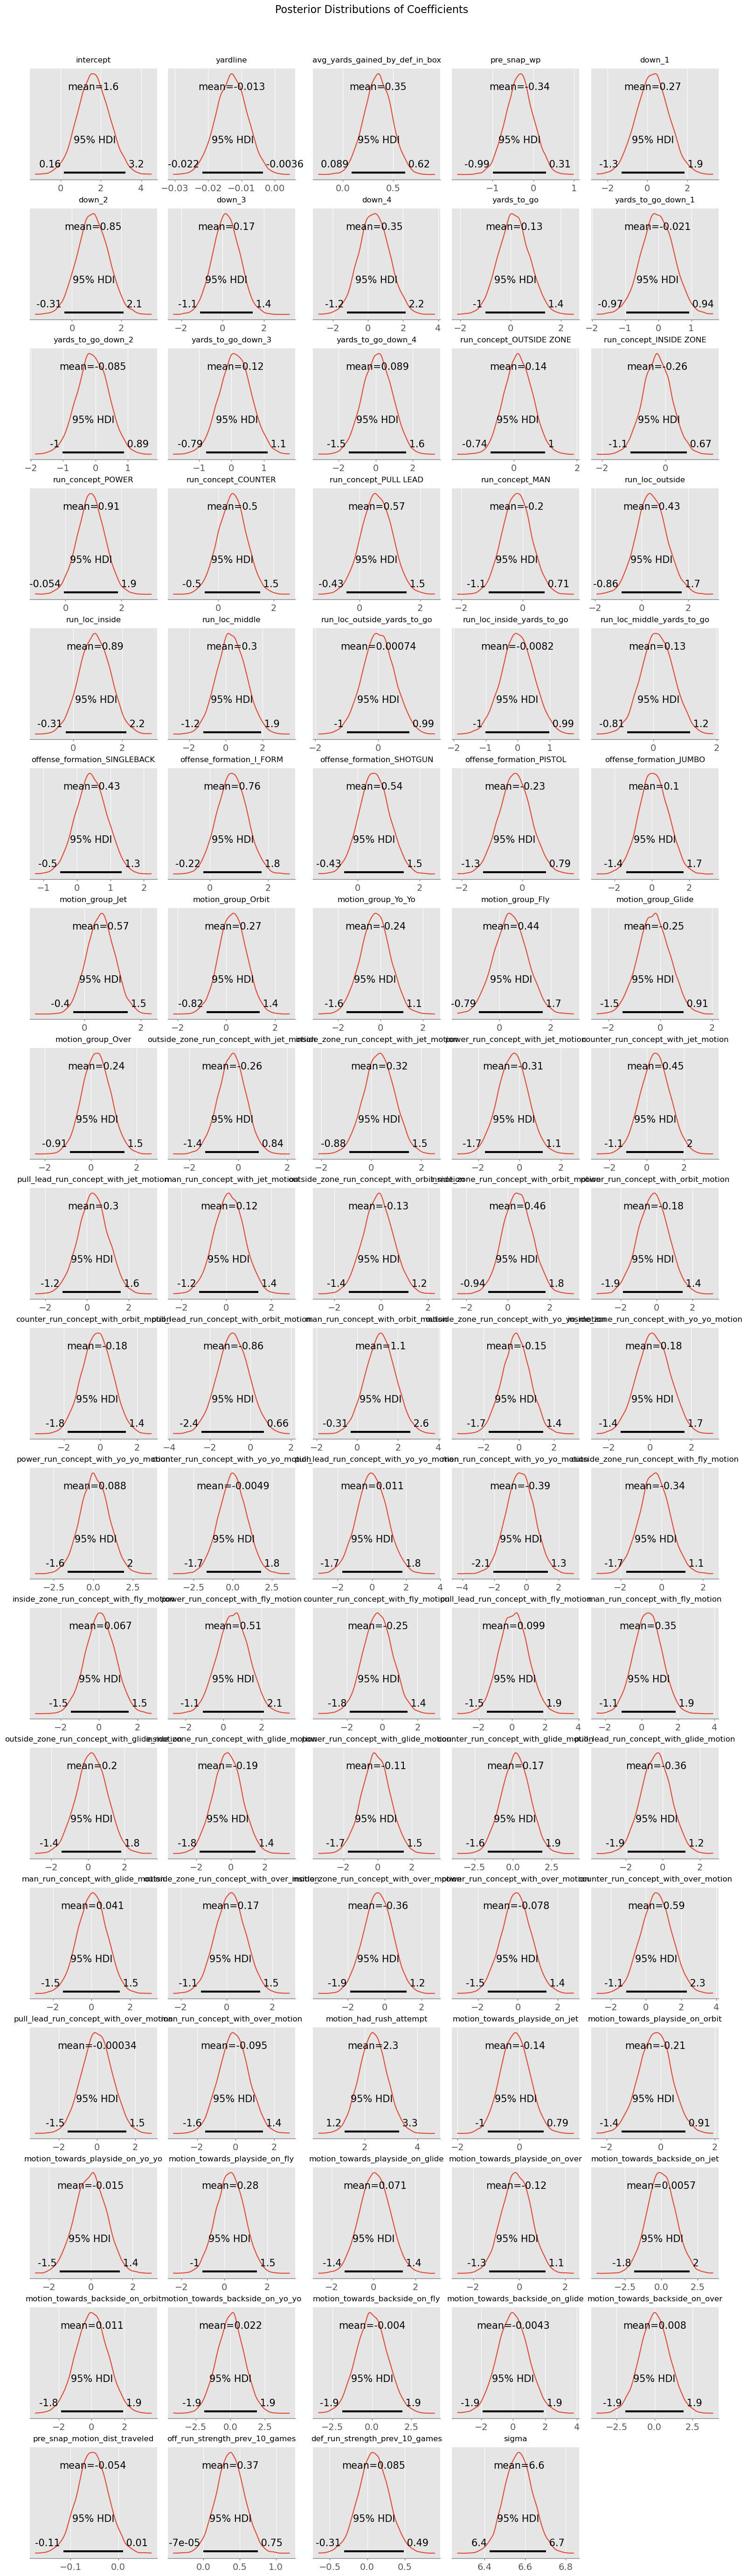

In [72]:
import arviz as az
import matplotlib.pyplot as plt
import math

# use ggplot theme
plt.style.use('ggplot')

# Visualize the distributions of each coefficient
coefficients = list(trace.posterior.data_vars)
posterior_samples = trace.posterior

# Create subplots for each coefficient
n_cols = 5
n_rows = math.ceil(len(coefficients) / n_cols)
fig_width = n_cols * 3
fig_height = n_rows * 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), constrained_layout=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot each coefficient
for ax, coeff in zip(axes, coefficients):
    # Plot the posterior distribution
    az.plot_posterior(posterior_samples[coeff], ax=ax, hdi_prob=0.95)
    
    # Set the title to the coefficient name
    ax.set_title(coeff, fontsize=12, pad=10)

# Hide any unused subplots
for ax in axes[len(coefficients):]:
    ax.axis('off')

# Display the plots
plt.suptitle('Posterior Distributions of Coefficients', fontsize=16, y=1.02)
plt.show()

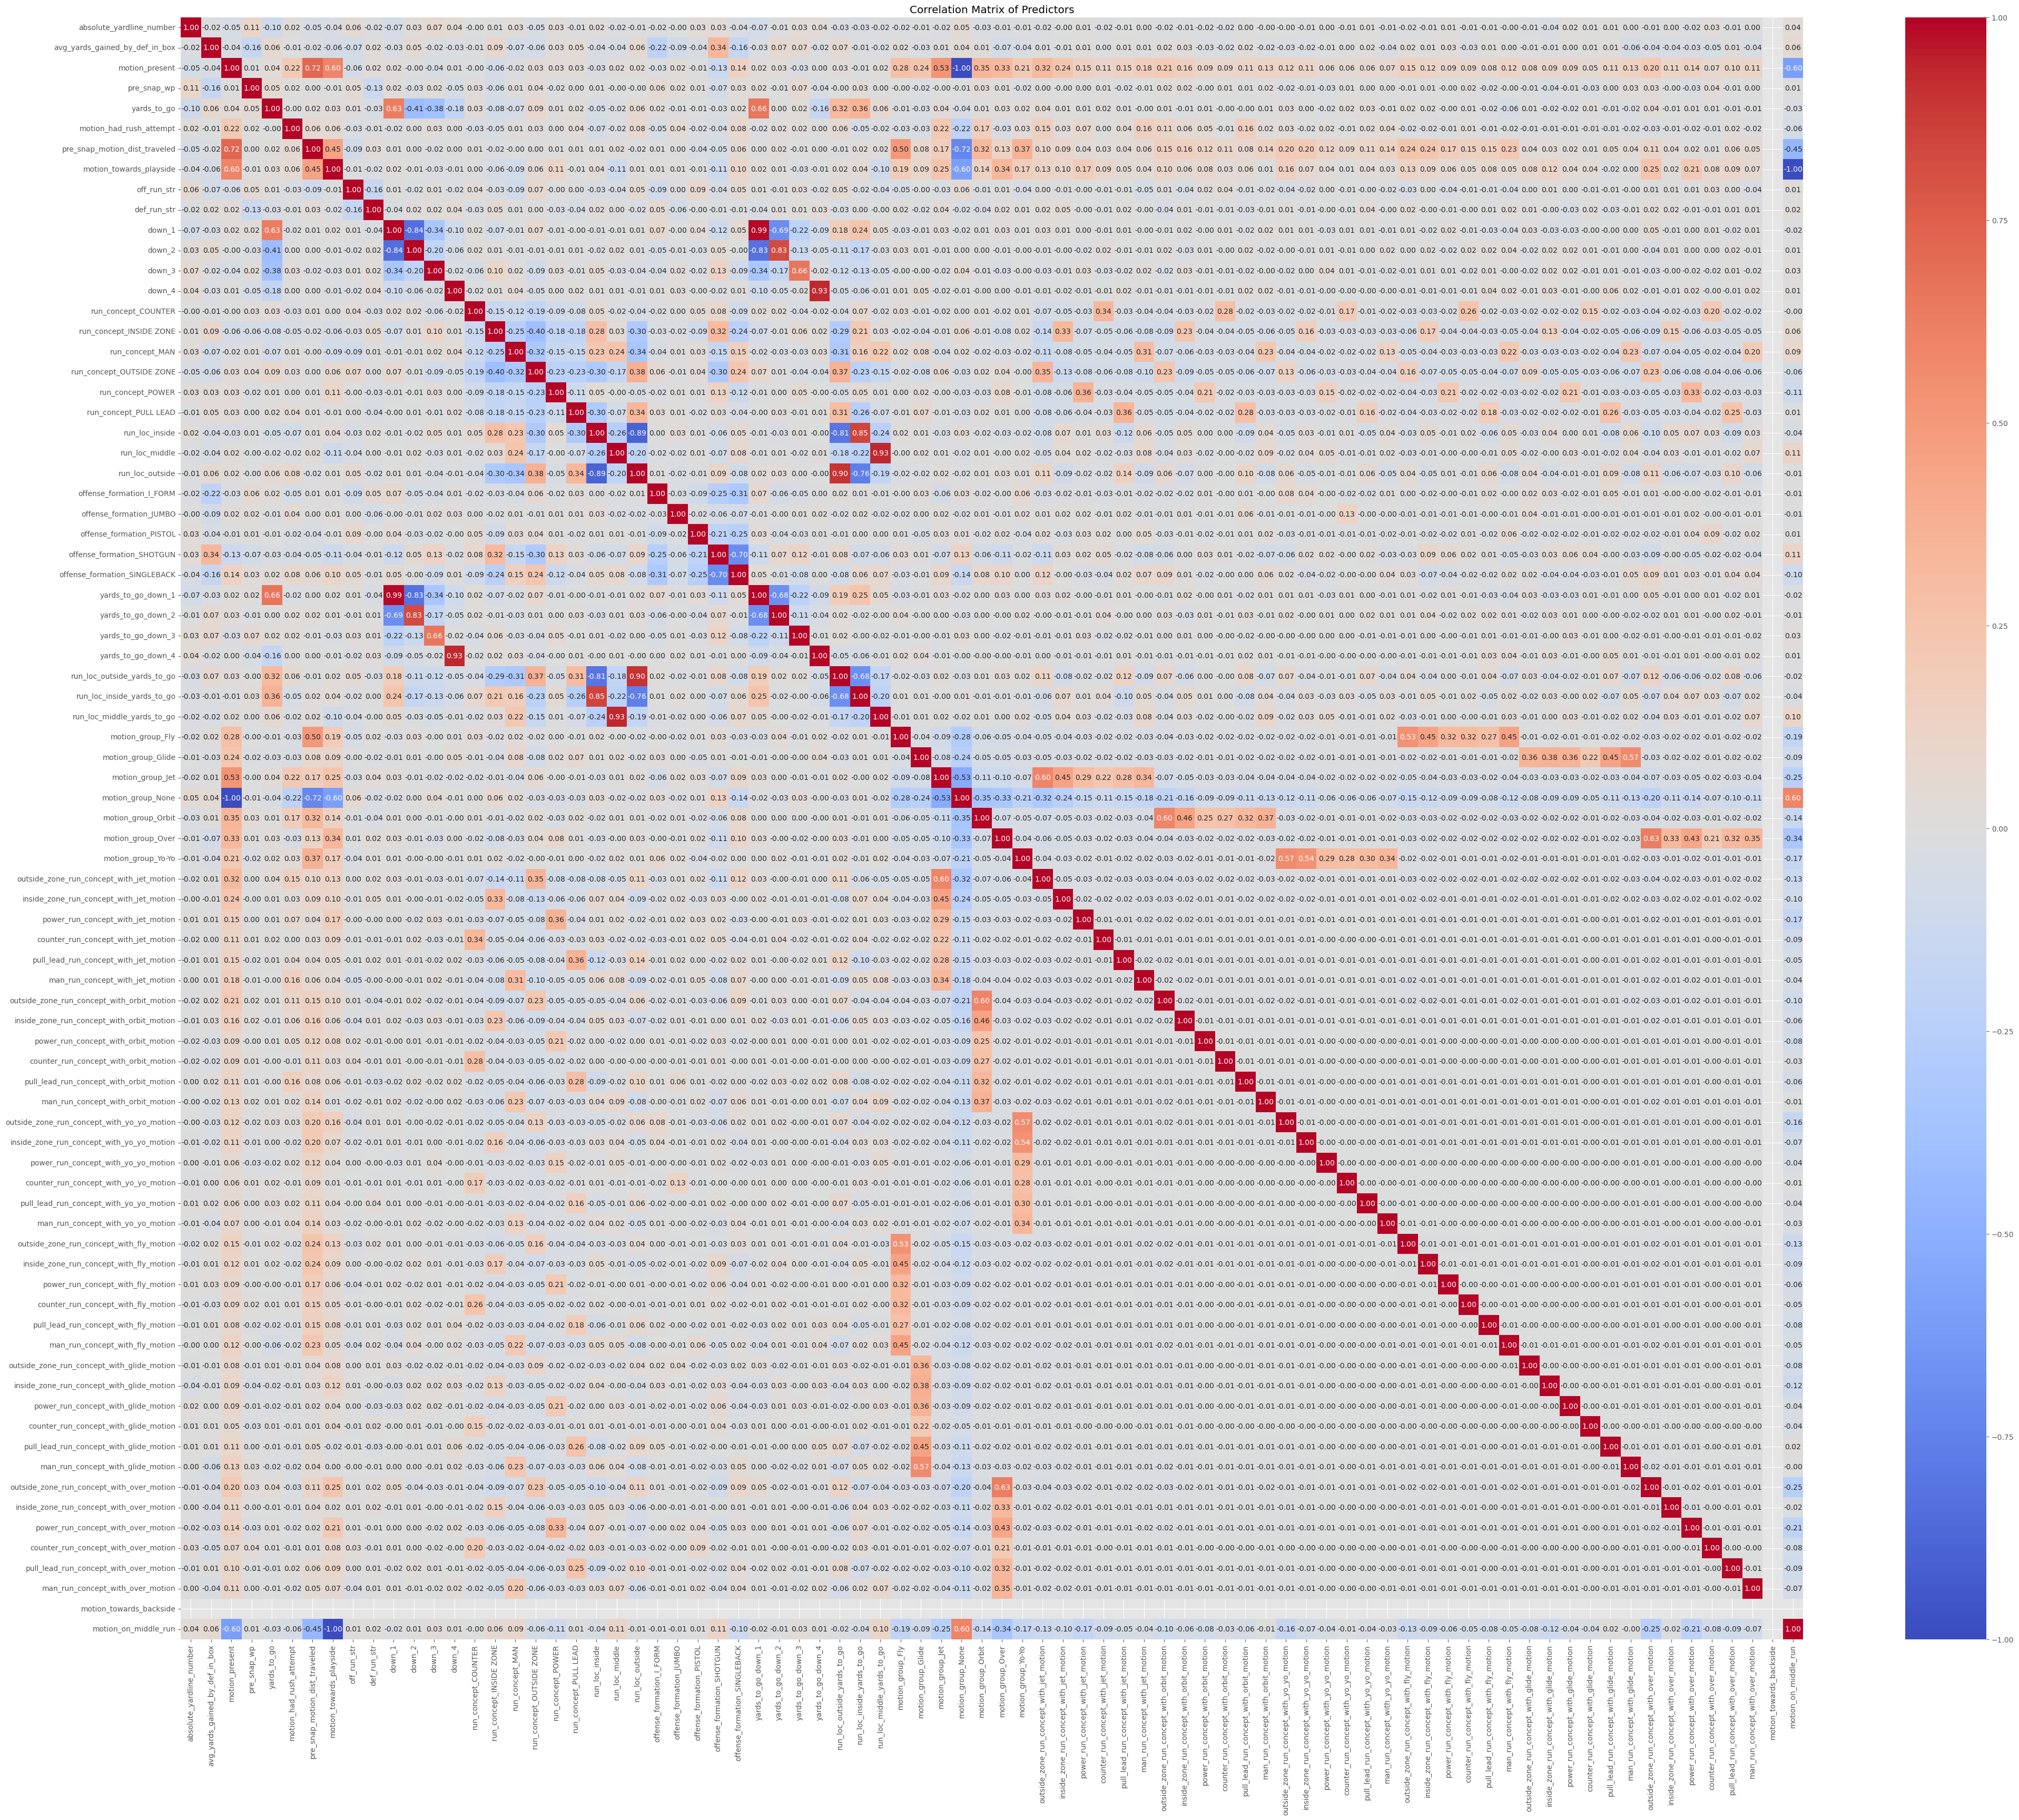

In [38]:
import seaborn as sns
# Calculate the correlation matrix
corr_matrix = X.corr()

# Plot the correlation matrix
plt.figure(figsize=(50, 40))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix of Predictors")
plt.show()

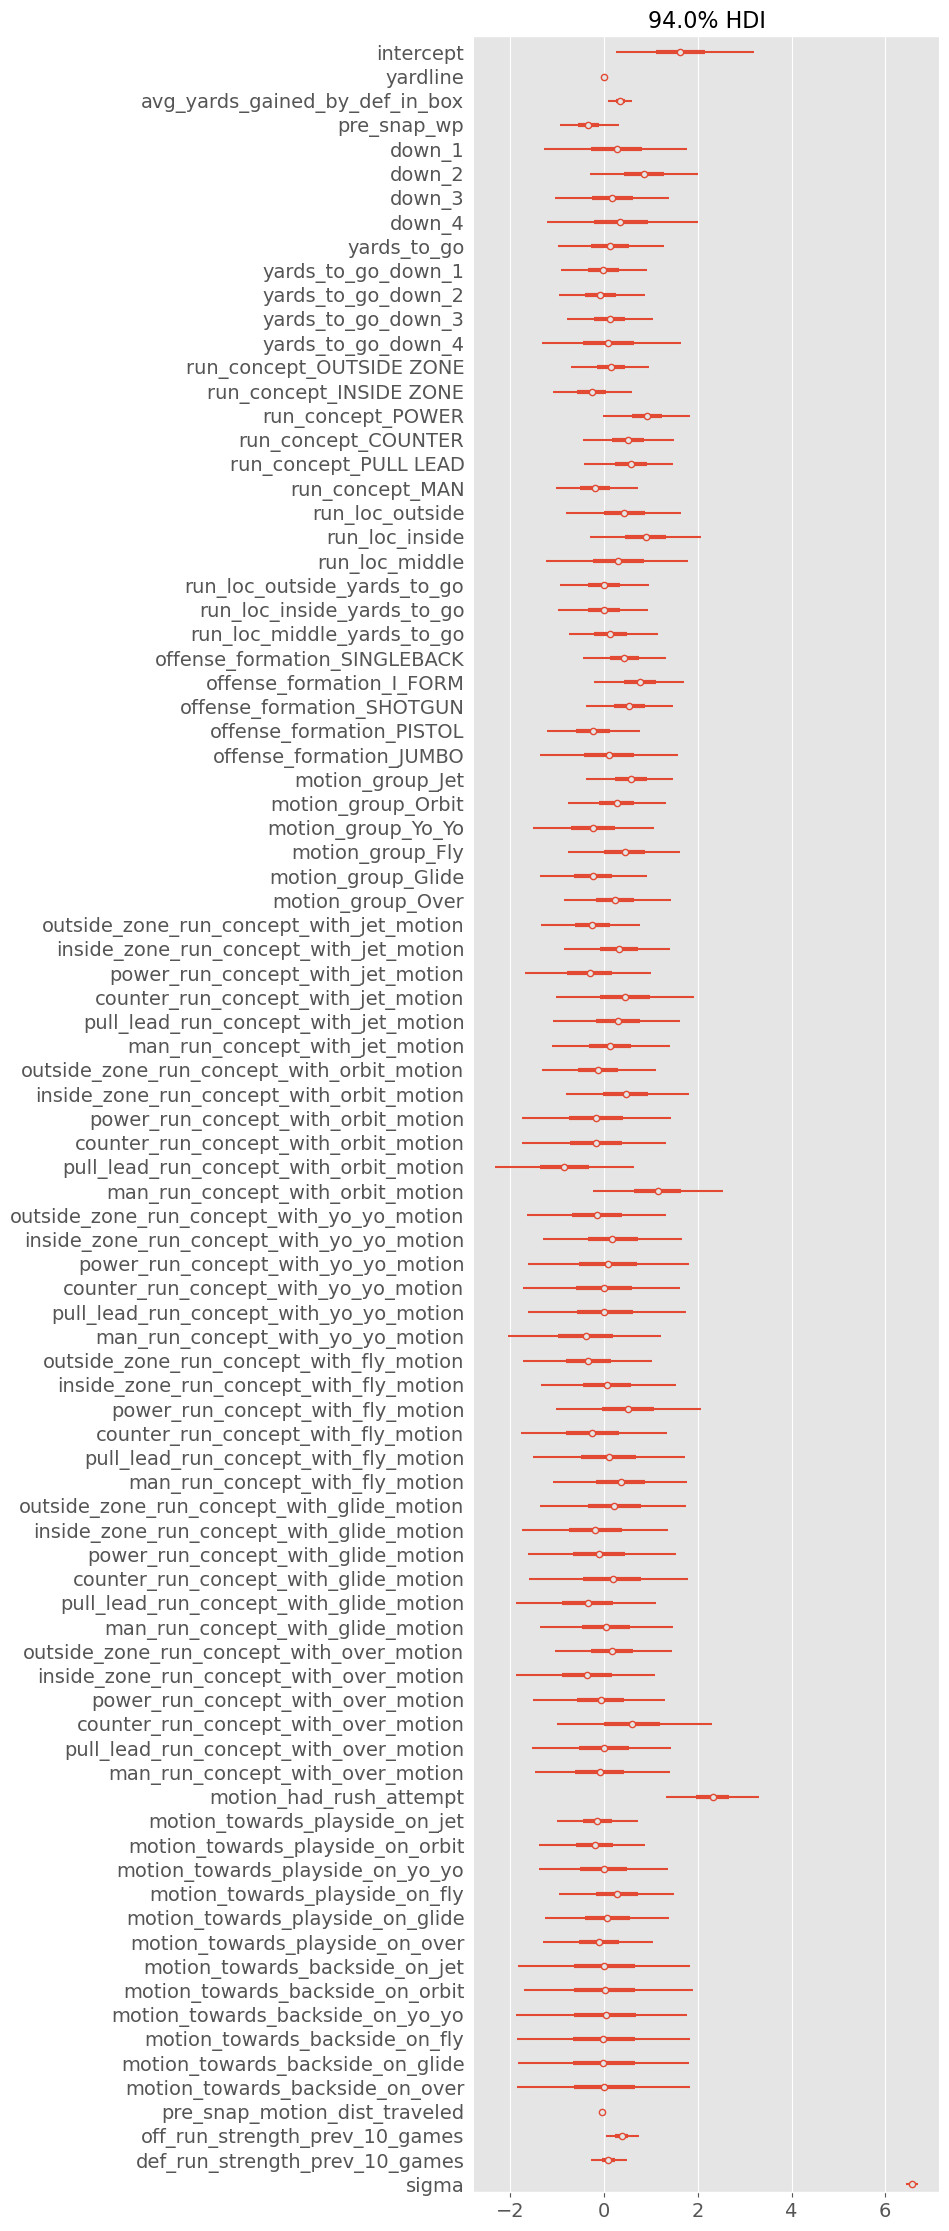

In [76]:
az.plot_forest(trace, figsize=(6, 28), combined=True)
plt.show()

In [77]:
with model:
    y_pred_trace = pm.sample_posterior_predictive(trace)

y_pred = y_pred_trace.posterior_predictive["yards_gained"].mean(axis=0).median(axis=0).values
y_obs = y["yards_gained"].values

r_squared = 1 - (np.var(y_obs - y_pred) / np.var(y_obs))
print(f"Bayesian R^2: {r_squared:.5f}")

Sampling: [yards_gained]


Output()

Bayesian R^2: 0.02221


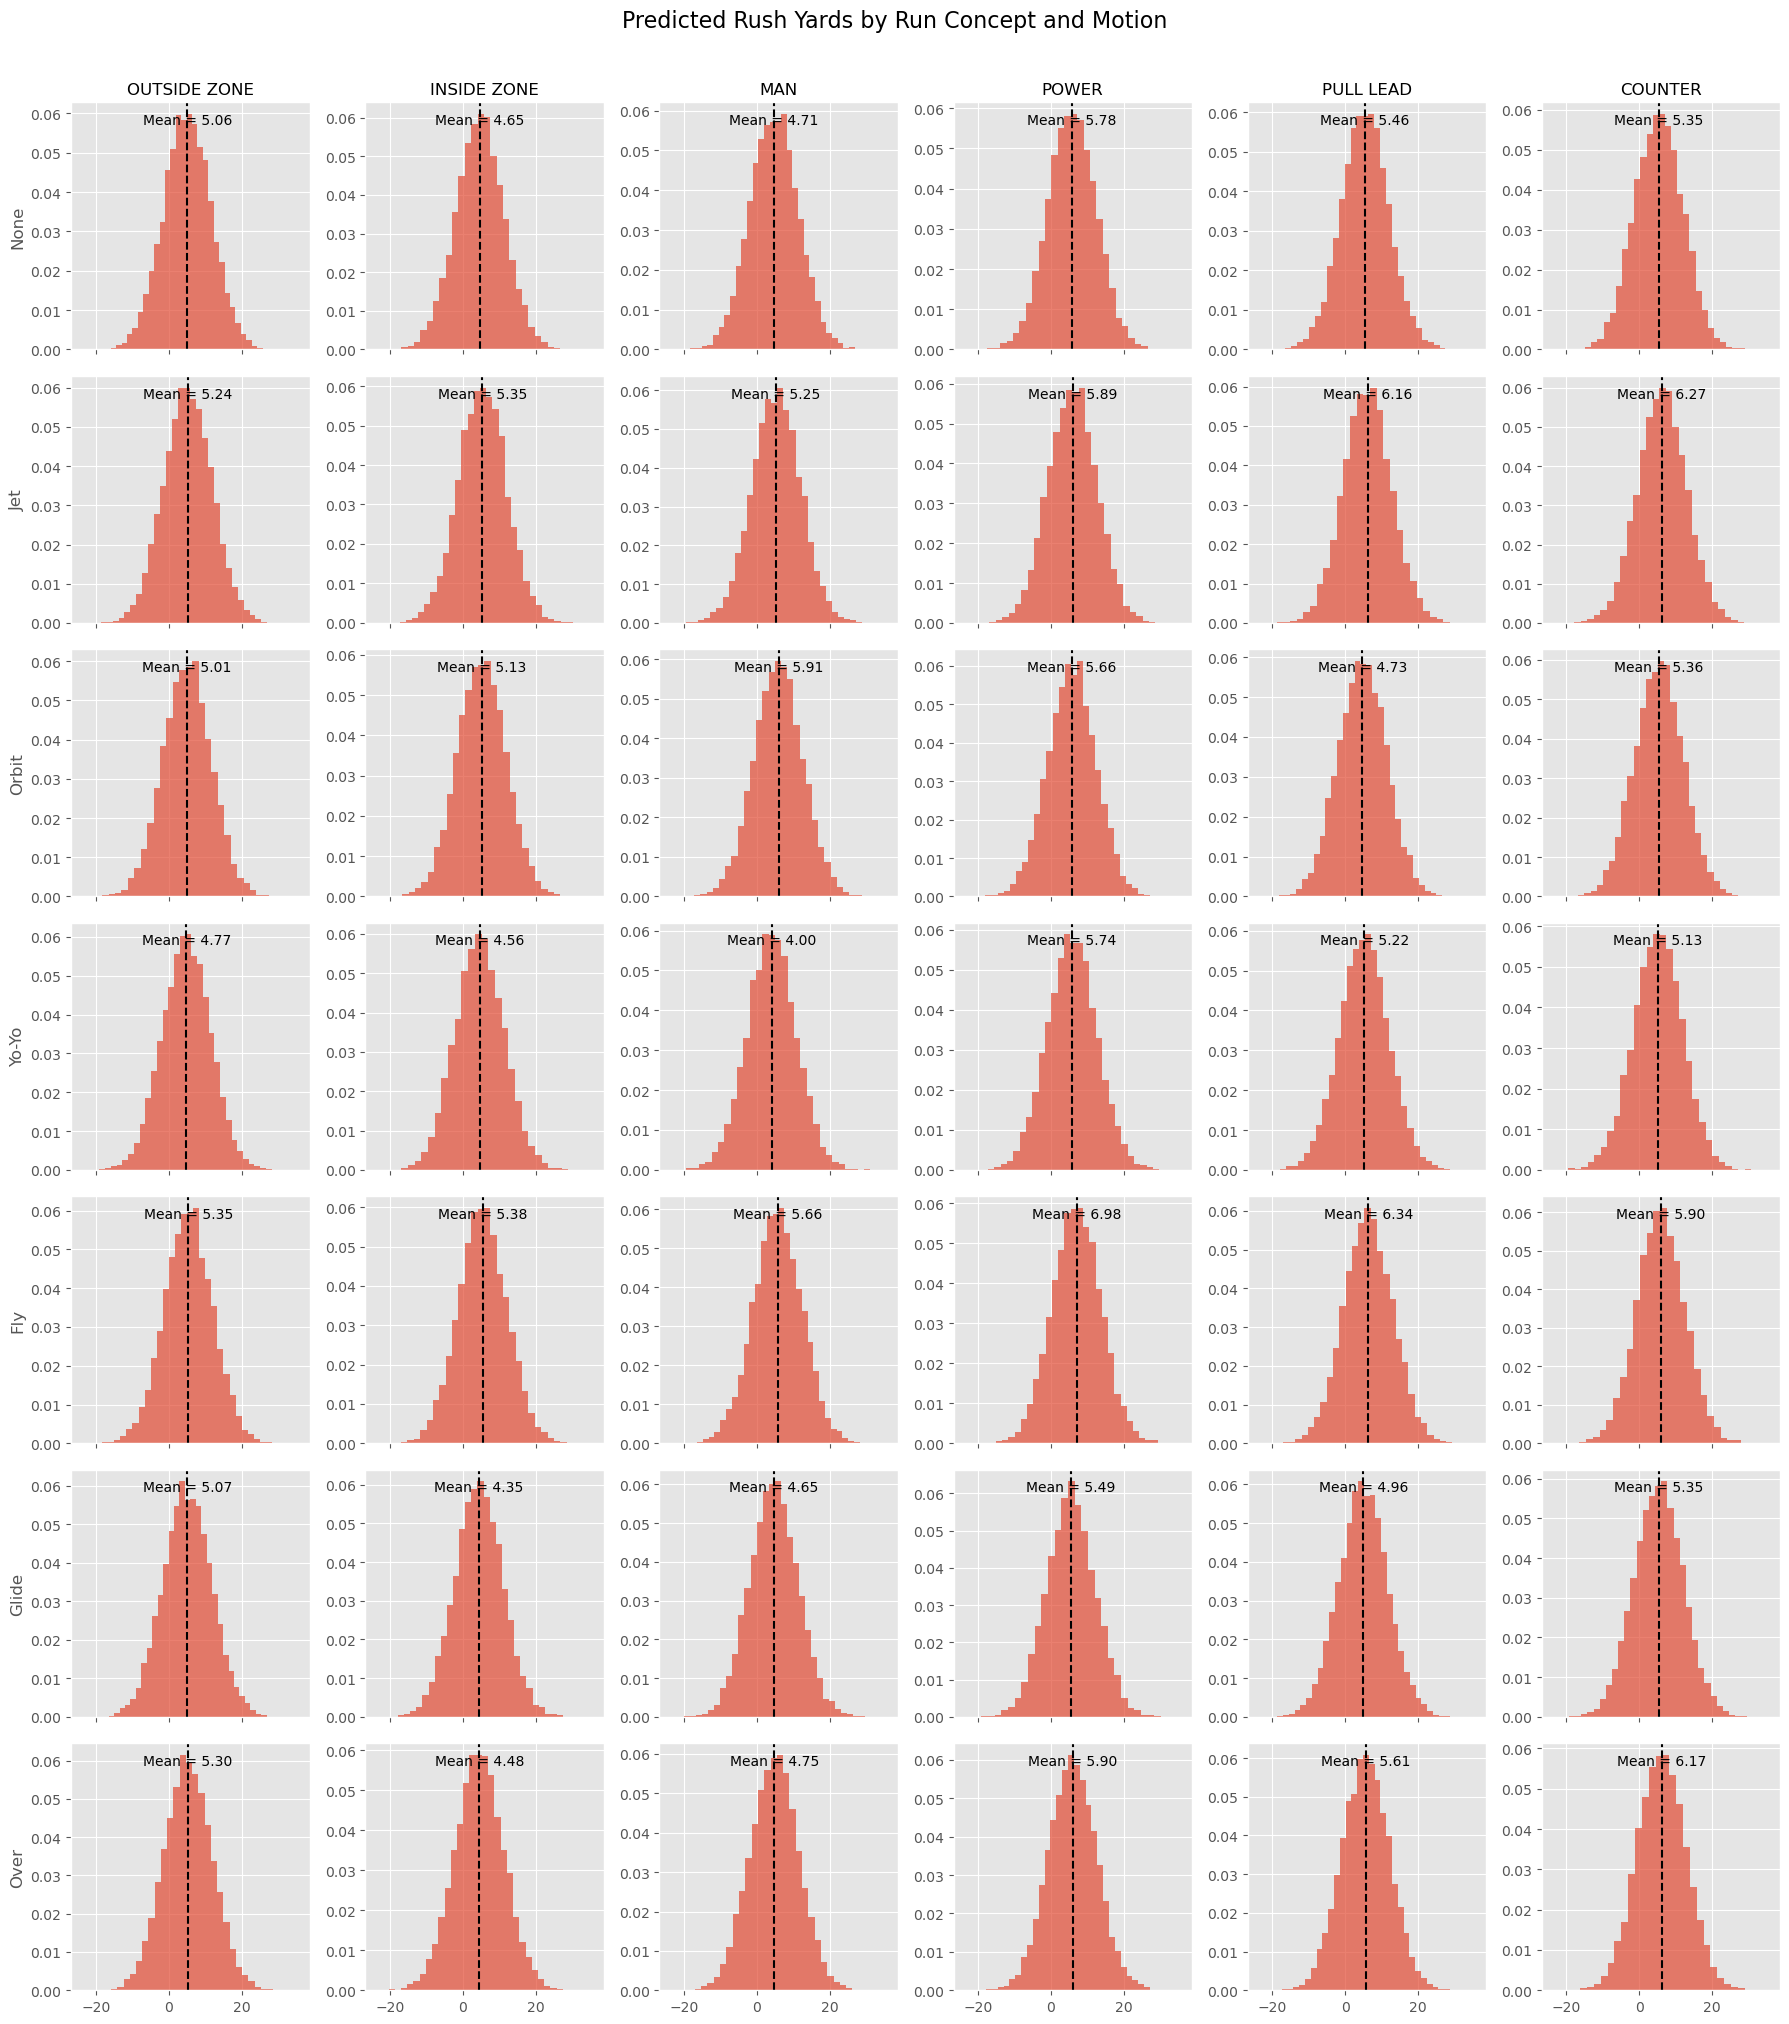

In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm

############################################
# 1) Create a "baseline" feature dictionary
############################################
baseline_dict = {
    'yardline': 30,
    'avg_yards_gained_by_def_in_box': avg_yards_gained_by_def_in_box.query('defenders_in_box == 6')['y_pred'].values[0],
    'pre_snap_wp': 0.5,
    'yards_to_go': 10,

    # Down dummy columns
    'down_1': 1,
    'down_2': 0,
    'down_3': 0,
    'down_4': 0,
    
    # Interaction
    'yards_to_go_down_1': 10,   # 10 * 1
    'yards_to_go_down_2': 0,
    'yards_to_go_down_3': 0,
    'yards_to_go_down_4': 0,

    # Run location
    'run_loc_outside': 1,
    'run_loc_inside': 0,
    'run_loc_middle': 0,
    'run_loc_outside_yards_to_go': 10, # 10 * 1
    'run_loc_inside_yards_to_go': 0,
    'run_loc_middle_yards_to_go': 0,

    # Offensive formations
    'offense_formation_SINGLEBACK': 1,
    'offense_formation_I_FORM': 0,
    'offense_formation_SHOTGUN': 0,
    'offense_formation_PISTOL': 0,
    'offense_formation_JUMBO': 0,

    # Other motion features
    'motion_had_rush_attempt': 0,
    'motion_towards_playside': 0,
    'motion_towards_backside': 1,
    'pre_snap_motion_dist_traveled': 0.0,

    # Team Run Grades Prev 10 Games
    'def_run_strength_prev_10_games': df.def_run_str.median(),
    'off_run_strength_prev_10_games': df.off_run_str.median()
}

###################################################
# 2) Define helper functions to compute predictions
###################################################
# Updated Run Concepts to include subgroups of MAN
run_concepts = ["OUTSIDE ZONE", "INSIDE ZONE", "MAN", "POWER", "PULL LEAD", "COUNTER"]
motions     = ["None", "Jet", "Orbit", "Yo-Yo", "Fly", "Glide", "Over"]
motion_directions = ["towards_playside", "towards_backside"]

def make_feature_row(run_concept, motion, baseline, motion_direction):
    row = baseline.copy()

    # Run concept
    for rc in ["POWER", "PULL LEAD", "COUNTER", "MAN", "OUTSIDE ZONE", "INSIDE ZONE"]:
        key = f"run_concept_{rc}"
        row[key] = 1 if rc == run_concept else 0

    # Motion group
    for mg in ["Jet", "Orbit", "Yo-Yo", "Fly", "Glide", "Over"]:
        key = f"motion_group_{mg.replace('-','_')}"
        row[key] = 1 if mg == motion else 0
    
    if motion == "None":
        for mg in ["Jet", "Orbit", "Yo-Yo", "Fly", "Glide", "Over"]:
            row[f"motion_group_{mg.replace('-','_')}"] = 0

    # Interactions (only set to 1 if both run_concept + motion match)
    for rc in ["POWER", "PULL LEAD", "COUNTER", "MAN", "OUTSIDE ZONE", "INSIDE ZONE"]:
        for mg in ["Jet", "Orbit", "Yo-Yo", "Fly", "Glide", "Over"]:
            row[f"{rc.lower().replace(' ','_')}_run_concept_with_{mg.lower().replace('-','_')}_motion"] = 1 if (run_concept == rc and motion == mg) else 0

    for mg in ["Jet", "Orbit", "Yo-Yo", "Fly", "Glide", "Over"]:
        for md in ["towards_playside", "towards_backside"]:
            row[f"motion_{md}_on_{mg.lower().replace('-','_')}"] = 1 if (motion == mg and motion_direction == md) else 0

    return row

def compute_posterior_predictive_for(row_dict, trace):
    """
    Given a single-row dictionary of feature values (matching the model's columns)
    and a PyMC InferenceData (trace), compute the predicted yards distribution.
    """
    # Convert row_dict to a DataFrame with 1 row
    df_row = pd.DataFrame([row_dict])

    # Extract the posterior from trace
    posterior = trace.posterior  # xarray with dims (chain, draw, parameter)

    # Grab draws of sigma [chain, draw]
    sigma_draws = posterior["sigma"].values
    # Intercept
    intercept_draws = posterior["intercept"].values

    # Start mu with the intercept draws
    mu_draws = intercept_draws.copy()

    # For each parameter in posterior, multiply by the row value if exists
    for par in posterior.data_vars:
        if par in ["intercept", "sigma", "yards_gained"]:
            continue
        if par in df_row.columns:
            coef_draws = posterior[par].values  # shape: [chain, draw]
            mu_draws += coef_draws * df_row.loc[0, par]

    # Flatten chain+draw
    mu_flat = mu_draws.reshape(-1)
    sigma_flat = sigma_draws.reshape(-1)

    # Posterior predictive distribution: sample from Normal(mu, sigma)
    predicted_yards = np.random.normal(loc=mu_flat, scale=sigma_flat)
    return predicted_yards

########################################################
# 3) Loop over all (Run Concept × Motion) combos & plot
########################################################
fig, axes = plt.subplots(nrows=len(motions), ncols=len(run_concepts),
                         figsize=(18, 20), sharex=True, sharey=False)
fig.suptitle("Predicted Rush Yards by Run Concept and Motion", fontsize=16, y=1.01)

for row_idx, motion in enumerate(motions):
    for col_idx, rc in enumerate(run_concepts):
        ax = axes[row_idx, col_idx]

        # Prepare features for (rc, motion)
        row_features = make_feature_row(run_concept=rc, motion=motion, baseline=baseline_dict, motion_direction="towards_playside")

        # Compute posterior predictive
        predicted = compute_posterior_predictive_for(row_features, trace)

        # Plot histogram of predictions
        ax.hist(predicted, bins=30, density=True, alpha=0.7, color='C0')

        # Compute and plot mean line
        mean_pred = np.mean(predicted)
        ax.axvline(mean_pred, color='k', linestyle='--')
        ax.text(
            mean_pred, 
            ax.get_ylim()[1] * 0.9, 
            f"Mean = {mean_pred:.2f}",
            ha='center',
            va='bottom',
            color='k'
        )

        # Label top row with run concept
        if row_idx == 0:
            ax.set_title(rc, fontsize=12)
        # Label left column with motion
        if col_idx == 0:
            ax.set_ylabel(motion, fontsize=12)

plt.tight_layout()
plt.show()

# Generate the Mean & Std Dev for Each Combination

In [69]:
(
    df
    .value_counts(['motion_group','motion_towards_playside'])
    .reset_index(name='count')
    .replace({'motion_towards_playside': {1: 'Playside', 0: 'Middle Run', -1: 'Backside'}})
    .sort_values(['motion_group', 'count'], ascending=False)
)

motion_group motion_towards_playside  count
9         Yo-Yo                Playside     65
11        Yo-Yo                Backside     41
17        Yo-Yo              Middle Run     10
2          Over                Playside    184
8          Over                Backside     67
14         Over              Middle Run     14
3         Orbit                Backside    170
4         Orbit                Playside    115
13        Orbit              Middle Run     19
0           Jet                Backside    334
1           Jet                Playside    258
12          Jet              Middle Run     37
7         Glide                Backside     81
10        Glide                Playside     54
15        Glide              Middle Run     11
5           Fly                Playside    100
6           Fly                Backside     83
16          Fly              Middle Run     10

In [217]:
import itertools
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
tqdm.pandas()

# Define configurable parameters
downs = ["down_1", "down_2", "down_3", "down_4"]
yards_to_go = range(1, 11)
run_concepts = ["OUTSIDE ZONE", "INSIDE ZONE", "PULL LEAD", "MAN", "POWER", "COUNTER"]
offense_formations = ["SINGLEBACK", "I_FORM", "SHOTGUN", "PISTOL", "JUMBO"]
motion_groups = ["None", "Jet", "Orbit", "Yo-Yo", "Fly", "Glide", "Over"]
motion_had_rush_attempt = [0, 1]
motion_directions = ["motion_towards_playside", "motion_towards_backside"]

# Constants
yardline = 40 # 30 yardline on far side of field (70 yards from endzone)
pre_snap_wp = 0.5
avg_yards_gained_by_def_in_box_const = avg_yards_gained_by_def_in_box.query('defenders_in_box == 6')['y_pred'].values[0]
median_pre_snap_motion_dist = df.groupby('motion_group').pre_snap_motion_dist_traveled.median()
median_pre_snap_motion_dist['None'] = 0.0
off_run_strength = df.off_run_str.median()
def_run_strength = df.def_run_str.median()

# Helper function to create a feature row
def create_feature_row(down, yards_to_go, run_concept, offense_formation, motion_group, motion_had_rush, motion_direction):
    # Base feature dictionary
    row = {
        'yardline': yardline,
        'avg_yards_gained_by_def_in_box': avg_yards_gained_by_def_in_box_const,
        'pre_snap_wp': pre_snap_wp,
        'yards_to_go': yards_to_go,
        'run_concept': run_concept,
        'offense_formation': offense_formation,
        'motion_group': motion_group,
        'motion_direction': motion_direction,
        'down': down,
        **{f'run_concept_{rc}': int(rc == run_concept) for rc in run_concepts},  # Run concept dummy
        **{d: int(d == down) for d in downs},  # Down dummy columns
        **{f'yards_to_go_{d}': yards_to_go if d == down else 0 for d in downs},  # Interaction with yards to go
        # Run location
        'run_loc_outside': int(run_concept in ["PULL LEAD", "OUTSIDE ZONE"]),
        'run_loc_inside': int(run_concept in ["POWER", "MAN", "INSIDE ZONE", "COUNTER"]),
        'run_loc_middle': 0,
        'run_loc_outside_yards_to_go': yards_to_go if run_concept in ["PULL LEAD", "OUTSIDE ZONE"] else 0,
        'run_loc_inside_yards_to_go': yards_to_go if run_concept in ["POWER", "MAN", "INSIDE ZONE", "COUNTER"] else 0,
        'run_loc_middle_yards_to_go': 0,
        # Offensive formation
        **{f'offense_formation_{formation}': int(offense_formation == formation) for formation in offense_formations},
        # Motion features
        **{f'motion_group_{mg.replace("-","_")}': int(motion_group == mg) for mg in motion_groups},
        'motion_had_rush_attempt': motion_had_rush,
        **{f'{direction}_on_{mg.lower().replace("-","_")}': int(motion_group == mg and motion_direction == direction) 
           for direction in motion_directions 
           for mg in motion_groups},  # Interaction with motion type
        # Run concept and motion interactions
        **{f'{rc.lower().replace(" ","_")}_run_concept_with_{mg.lower().replace("-","_")}_motion': int(rc == run_concept and mg == motion_group) 
           for rc in run_concepts 
           for mg in motion_groups},
        'pre_snap_motion_dist_traveled': median_pre_snap_motion_dist[motion_group],
        'off_run_strength_prev_10_games': off_run_strength,
        'def_run_strength_prev_10_games': def_run_strength,
    }
    return row

def compute_posterior_predictive_for(row_dict, trace):
    """
    Given a single-row dictionary of feature values (matching the model's columns)
    and a PyMC InferenceData (trace), compute the predicted yards distribution.
    """
    # Convert row_dict to a DataFrame with 1 row
    df_row = pd.DataFrame([row_dict])

    # Extract the posterior from trace
    posterior = trace.posterior  # xarray with dims (chain, draw, parameter)

    # Grab draws of sigma [chain, draw]
    sigma_draws = posterior["sigma"].values
    # Intercept
    intercept_draws = posterior["intercept"].values

    # Start mu with the intercept draws
    mu_draws = intercept_draws.copy()

    # For each parameter in posterior, multiply by the row value if exists
    for par in posterior.data_vars:
        if par in ["intercept", "sigma", "yards_gained"]:
            continue
        if par in df_row.columns:
            coef_draws = posterior[par].values  # shape: [chain, draw]
            mu_draws += coef_draws * df_row.loc[0, par]
        else:
            print(f"Skipping {par}")
            print(df_row)
            raise ValueError(f"Missing parameter {par}")

    # Flatten chain+draw
    mu_flat = mu_draws.reshape(-1)
    sigma_flat = sigma_draws.reshape(-1)

    # Posterior predictive distribution: sample from Normal(mu, sigma)
    predicted_yards = np.random.normal(loc=mu_flat, scale=sigma_flat)
    return predicted_yards

# Iterate over all combinations of configurable parameters
results = []
combinations = itertools.product(downs, yards_to_go, run_concepts, offense_formations, motion_groups, motion_had_rush_attempt, motion_directions)
n_combinations = len(downs) * len(yards_to_go) * len(run_concepts) * len(offense_formations) * \
      len(motion_groups) * len(motion_had_rush_attempt) * len(motion_directions)
for combo in tqdm(combinations, total=n_combinations):
    down, ytg, rc, formation, motion, had_rush, direction = combo
    row = create_feature_row(down, ytg, rc, formation, motion, had_rush, direction)

    # Compute posterior predictive distribution
    predicted = compute_posterior_predictive_for(row, trace)
    mean_pred = np.mean(predicted)
    std_pred = np.std(predicted)
    
    # Store results
    results.append({
        **row,
        'mean_predicted_rush_yards': mean_pred,
        'std_predicted_rush_yards': std_pred
    })

# Create a dataframe from the results
df_results = pd.DataFrame(results)

  0%|          | 0/33600 [00:00<?, ?it/s]

In [218]:
# Validate that all model coefficients are present in the feature rows (excluding "None" motion group)
# Also, some extra cols present which are the non-one-hot encoded versions of the one-hot encoded cols
set(list(row.keys())) - set(list(trace.posterior.data_vars))

{'counter_run_concept_with_none_motion',
 'down',
 'inside_zone_run_concept_with_none_motion',
 'man_run_concept_with_none_motion',
 'motion_direction',
 'motion_group',
 'motion_group_None',
 'motion_towards_backside_on_none',
 'motion_towards_playside_on_none',
 'offense_formation',
 'outside_zone_run_concept_with_none_motion',
 'power_run_concept_with_none_motion',
 'pull_lead_run_concept_with_none_motion',
 'run_concept'}

In [219]:
# Validate that intercept and sigma are not present in the feature rows
set(list(trace.posterior.data_vars)) - set(list(row.keys()))

{'intercept', 'sigma'}

In [220]:
df_results.head()

yardline  avg_yards_gained_by_def_in_box  pre_snap_wp  yards_to_go  \
0        40                        4.689824          0.5            1   
1        40                        4.689824          0.5            1   
2        40                        4.689824          0.5            1   
3        40                        4.689824          0.5            1   
4        40                        4.689824          0.5            1   

    run_concept offense_formation motion_group         motion_direction  \
0  OUTSIDE ZONE        SINGLEBACK         None  motion_towards_playside   
1  OUTSIDE ZONE        SINGLEBACK         None  motion_towards_backside   
2  OUTSIDE ZONE        SINGLEBACK         None  motion_towards_playside   
3  OUTSIDE ZONE        SINGLEBACK         None  motion_towards_backside   
4  OUTSIDE ZONE        SINGLEBACK          Jet  motion_towards_playside   

     down  run_concept_OUTSIDE ZONE  run_concept_INSIDE ZONE  \
0  down_1                         1                        0   
1  down_1                         1                        0   
2  down_1                         1                        0   
3  down_1                         1                        0   
4  down_1                         1                        0   

   run_concept_PULL LEAD  run_concept_MAN  run_concept_POWER  \
0                      0                0                  0   
1                      0                0                  0   
2                      0                0                  0   
3                      0                0                  0   
4                      0                0                  0   

   run_concept_COUNTER  down_1  down_2  down_3  down_4  yards_to_go_down_1  \
0                    0       1       0       0       0                   1   
1                    0       1       0       0       0                   1   
2                    0       1       0       0       0                   1   
3                    0       1       0       0       0                   1   
4                    0       1       0       0       0                   1   

   yards_to_go_down_2  yards_to_go_down_3  yards_to_go_down_4  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   run_loc_outside  run_loc_inside  run_loc_middle  \
0                1               0               0   
1                1               0               0   
2                1               0               0   
3                1               0               0   
4                1               0               0   

   run_loc_outside_yards_to_go  run_loc_inside_yards_to_go  \
0                            1                           0   
1                            1                           0   
2                            1                           0   
3                            1                           0   
4                            1                           0   

   run_loc_middle_yards_to_go  offense_formation_SINGLEBACK  \
0                           0                             1   
1                           0                             1   
2                           0                             1   
3                           0                             1   
4                           0                             1   

   offense_formation_I_FORM  offense_formation_SHOTGUN  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   offense_formation_PISTOL  offense_formation_JUMBO  mot

In [222]:
keep_cols = [
    'yards_to_go', 
    'run_concept', 
    'offense_formation', 
    'motion_group',
    'motion_direction', 
    'down',
    'motion_had_rush_attempt',
    'mean_predicted_rush_yards',
    'std_predicted_rush_yards'
]

df_results = df_results[keep_cols]

In [223]:
df_results.head()

yards_to_go   run_concept offense_formation motion_group  \
0            1  OUTSIDE ZONE        SINGLEBACK         None   
1            1  OUTSIDE ZONE        SINGLEBACK         None   
2            1  OUTSIDE ZONE        SINGLEBACK         None   
3            1  OUTSIDE ZONE        SINGLEBACK         None   
4            1  OUTSIDE ZONE        SINGLEBACK          Jet   

          motion_direction    down  motion_had_rush_attempt  \
0  motion_towards_playside  down_1                        0   
1  motion_towards_backside  down_1                        0   
2  motion_towards_playside  down_1                        1   
3  motion_towards_backside  down_1                        1   
4  motion_towards_playside  down_1                        0   

   mean_predicted_rush_yards  std_predicted_rush_yards  
0                   3.910479                  6.613378  
1                   3.979536                  6.583532  
2                   6.268100                  6.657487  
3                   6.188415                  6.612878  
4                   3.857864                  6.634619

In [224]:
df_results['run_concept'] = df_results['run_concept'].str.title()
df_results['offense_formation'] = df_results['offense_formation'].str.replace('_', '-').str.title()
df_results['motion_direction'] = df_results['motion_direction'].str.replace('_', ' ').str.title().str.replace('Motion ','')

down_map = {
    'down_1': '1st',
    'down_2': '2nd',
    'down_3': '3rd',
    'down_4': '4th'
}
df_results['down'] = df_results['down'].map(down_map)

motion_had_rush_map = {
    0: 'No',
    1: 'Yes'
}
df_results['motion_had_rush_attempt'] = df_results['motion_had_rush_attempt'].map(motion_had_rush_map)

In [236]:
df_results.head()

yards_to_go   run_concept offense_formation motion_group  motion_direction  \
0            1  Outside Zone        Singleback         None  Towards Playside   
1            1  Outside Zone        Singleback         None  Towards Backside   
2            1  Outside Zone        Singleback         None  Towards Playside   
3            1  Outside Zone        Singleback         None  Towards Backside   
4            1  Outside Zone        Singleback          Jet  Towards Playside   

  down motion_had_rush_attempt  mean_predicted_rush_yards  \
0  1st                      No                   3.910479   
1  1st                      No                   3.979536   
2  1st                     Yes                   6.268100   
3  1st                     Yes                   6.188415   
4  1st                      No                   3.857864   

   std_predicted_rush_yards  
0                  6.613378  
1                  6.583532  
2                  6.657487  
3                  6.612878  
4                  6.634619

In [238]:
df_results.to_parquet(join(RAW_DATA_PATH, 'model_results.parquet'), index=False)